# Прогнозирование оттока клиентов в сети отелей

## Описание проекта

**`Постановка задачи`**<br>
Чтобы привлечь клиентов, сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако, если клиент отменял бронирование, то компания терпела убытки.

Чтобы решить эту проблему, необходимо разработать систему, которая *предсказывает отказ от брони*. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

**`Бизнес-метрика и другие данные`**<br>
Основная бизнес-метрика - прибыль. Прибыль рассчитывается как разница между стоимостью номера за все ночи и затраты на обслуживание как при подготовке номера, так и при проживании постояльца.
В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.
Стоимость номеров отеля:

- категория A: за ночь — 1 000, разовое обслуживание — 400;
- категория B: за ночь — 800, разовое обслуживание — 350;
- категория C: за ночь — 600, разовое обслуживание — 350;
- категория D: за ночь — 550, разовое обслуживание — 150;
- категория E: за ночь — 500, разовое обслуживание — 150;
- категория F: за ночь — 450, разовое обслуживание — 150;
- категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: 
- весной и осенью цены повышаются на 20%
- летом — на 40%.

На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за год. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

## Импорт библиотек, загрузка данных

Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from math import ceil

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import SCORERS
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix

from sklearn.utils import shuffle

import warnings

Установка параметров, присвоение значений констант

In [2]:
# устанавливаем формат отображения float в 3 знака в дробной части
pd.set_option('display.float_format', '{:.3f}'.format)

# устанавливаем макс. значение для отображения столбцов 45
pd.options.display.max_columns = 45

# отключаем предупреждения
warnings.filterwarnings("ignore")

RND_ST = 42
N_FLDS = 5
DEPOSITE_RATE = .8

In [3]:
df_train = pd.read_csv('datasets/hotel_train.csv')
df_test = pd.read_csv('datasets/hotel_test.csv')

In [4]:
df_train.shape, df_test.shape

((65229, 25), (32412, 25))

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

In [7]:
df_train.sample(5, random_state=RND_ST)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
35671,43611,1,64.000,2016,November,47,17,0,3,3.000,0.000,0.000,BB,ESP,TA/TO,0,0,0,D,0,0,Transient,0,2,3
5692,5762,1,135.000,2016,November,46,10,2,3,2.000,0.000,0.000,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,0,5
52324,70897,0,32.000,2016,May,23,29,2,3,2.000,1.000,0.000,BB,BEL,Direct,0,0,0,E,0,0,Transient,0,1,5
36791,44731,1,16.000,2016,December,53,28,2,4,2.000,0.000,0.000,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,6
17455,25395,0,16.000,2015,August,32,8,2,2,1.000,0.000,0.000,BB,POL,TA/TO,0,0,0,A,1,0,Transient-Party,0,0,4


In [8]:
df_test.sample(5, random_state=RND_ST)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
31071,96563,0,271.000,2017,August,31,2,2,5,2.000,0.000,0.000,BB,FRA,TA/TO,0,0,0,A,0,0,Transient,0,1,7
11119,48308,1,248.000,2017,April,15,9,2,0,2.000,0.000,0.000,BB,PRT,TA/TO,0,0,0,A,0,0,Transient-Party,0,0,2
4756,21695,0,1.000,2017,April,13,1,0,1,2.000,0.000,0.000,BB,PRT,TA/TO,0,0,0,A,1,0,Transient,0,1,1
11753,48942,1,251.000,2017,April,16,21,1,2,2.000,0.000,0.000,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,2,3
22046,87538,0,21.000,2017,March,11,15,0,2,1.000,0.000,0.000,SC,DEU,GDS,0,0,0,A,0,0,Transient,0,0,2


In [9]:
display('Тренировочные данные', df_train.describe(include='object'))
display('Тестовые данные', df_test.describe(include='object'))

'Тренировочные данные'

,arrival_date_month,meal,country,distribution_channel,reserved_room_type,customer_type
count,65229,65229,65229,65229,65229,65229
unique,12,5,155,4,7,4
top,October,BB,PRT,TA/TO,A,Transient
freq,9255,51697,28831,54454,50501,45493


'Тестовые данные'

,arrival_date_month,meal,country,distribution_channel,reserved_room_type,customer_type
count,32412,32412,32412,32412,32412,32412
unique,8,5,143,4,7,4
top,May,BB,PRT,TA/TO,A,Transient
freq,5262,24684,9887,27083,23471,27461


In [10]:
display('Тренировочные данные', df_train.describe(include=['float', 'int']))
display('Тестовые данные', df_test.describe(include=['float', 'int']))

'Тренировочные данные'

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000,65229.000
mean,43544.069,0.369,96.338,2015.719,31.340,15.848,0.825,2.225,1.837,0.075,0.007,0.027,0.129,0.108,0.194,3.334,0.057,0.513,3.050
std,25614.859,0.482,96.128,0.449,13.464,8.748,0.853,1.355,0.480,0.334,0.099,0.163,0.965,1.327,0.594,18.240,0.232,0.753,1.738
min,0.000,0.000,0.000,2015.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
25%,19108.000,0.000,17.000,2015.000,21.000,8.000,0.000,1.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000
50%,40554.000,0.000,64.000,2016.000,34.000,16.000,1.000,2.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000
75%,67414.000,1.000,151.000,2016.000,42.000,23.000,2.000,3.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,4.000
max,84121.000,1.000,374.000,2016.000,53.000,31.000,4.000,6.000,4.000,3.000,10.000,1.000,26.000,58.000,17.000,259.000,3.000,5.000,10.000


'Тестовые данные'

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000,32412.000,32412.000,32412.000,32412.000,32412.000,32412.000,32412.000,32412.000,32412.000,32412.000,32412.000,32412.000,32412.000,32412.000,32412.000,32412.000,32412.000,32412.000
mean,60131.505,0.388,97.588,2017.000,17.804,15.657,0.868,2.340,1.859,0.084,0.006,0.031,0.012,0.171,0.217,0.262,0.046,0.658,3.208
std,29953.586,0.487,86.507,0.000,9.177,8.766,0.853,1.375,0.489,0.343,0.076,0.174,0.180,1.875,0.641,4.733,0.219,0.834,1.739
min,6086.000,0.000,0.000,2017.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
25%,45291.750,0.000,23.000,2017.000,10.000,8.000,0.000,1.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000
50%,53394.500,0.000,76.000,2017.000,18.000,15.500,1.000,2.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000
75%,89800.250,1.000,155.000,2017.000,25.000,23.000,2.000,3.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,4.000
max,97903.000,1.000,373.000,2017.000,35.000,31.000,4.000,6.000,4.000,3.000,2.000,1.000,6.000,72.000,18.000,223.000,8.000,5.000,10.000


Явных дубликатов нет (так как есть столбец `id`)

In [11]:
print('Дубликатов в тренировочных данных:', df_train.duplicated().sum())
print('Дубликатов в тестовых данных:', df_test.duplicated().sum())

Дубликатов в тренировочных данных: 0
Дубликатов в тестовых данных: 0


Но если посмотреть на данные без столбца `id`, то дубликатов довольно много:

In [12]:
print('Дубликатов в тренировочных данных (без id):', df_train.drop(['id'], axis=1).duplicated().sum())
print('Дубликатов в тестовых данных (без id):', df_test.drop(['id'], axis=1).duplicated().sum())

Дубликатов в тренировочных данных (без id): 21377
Дубликатов в тестовых данных (без id): 7717


Распределение целевого признака в тренировочном датасете и в тренировочных дубликатах:

In [13]:
print('Баланс классов в тренировочном датасете') 
print(df_train['is_canceled'].value_counts().sort_index(), '\n')
print('Баланс классов в дубликатах тренировочного датасета')
print(df_train[df_train.drop(['id'], axis=1).duplicated()]['is_canceled'].value_counts().sort_index())

Баланс классов в тренировочном датасете
0    41185
1    24044
Name: is_canceled, dtype: int64 

Баланс классов в дубликатах тренировочного датасета
0     8481
1    12896
Name: is_canceled, dtype: int64


Удалим все дубликаты в тренировочных данных, сохранив чистые данные в датафреймы `df_train_wo_dupl` и `df_test_wo_dupl`. Несмотря на то, что мы сместим балланс классов, мы сможем точнее назначить диапазоны классификации количественных признаков.

In [14]:
def dupl_drop(df):
    df = df.drop(
        index = df[df.drop(['id'], axis=1).duplicated()][df['is_canceled'] == 0].index
    ).reset_index(drop=True)
    df = df.drop(
        index = df[df.drop(['id'], axis=1).duplicated()][df['is_canceled'] == 1].index
    ).reset_index(drop=True)
    return df

df_train = dupl_drop(df_train)
df_test = dupl_drop(df_test)

In [15]:
df_train.shape, df_test.shape

((43852, 25), (24695, 25))

### Вывод

<a id=intro_conclusion> </a>

Датасеты загружены, размеры тренировочного и тестового `(65229, 25), (32412, 25)`. Пропусков в данных нет, наименования столбцов соответствуют принятым стандартам (строчные буквы, разделение `_`). 

По типам данных все соответствует:

- Тренировочные данные: `float64(4)`, `int64(15)`, `object(6)`
- Тестовые данные: `float64(4)`, `int64(15)`, `object(6)`

В строковых данных отличия наблюдаются в кол-ве уникальных значений в столбцах `arrival_date_month` (12 и 8), `arrival_date_week_number` (53 и 35) и `country` (155 и 143)

В числовых данных видим следующее:
- все данные категориальные, кроме `lead_time` и `days_in_waiting_list`.
- значения в `arrival_date_year` не имеет смысла включать в дальнейшем как признак.
- значения в `arrival_date_week_number` являются следствием данных в столбцах `arrival_date_year`, `arrival_date_month` и `arrival_date_day_of_month` - также скорее всего как признак не потребуется.
- необходимо проверить на выбросы данные в столобцах `babies`, `previous_cancellations, previous_bookings_not_canceled, booking_changes, days_in_waiting_list, required_car_parking_spaces`

Проверили на дубликаты, очистили данные. Размеры очищенных датасетов ((43852, 25), (24695, 25))

## Предобработка и исследовательский анализ данных

### Балланс классов

Перед нами задача классификации, целевой признак - отмена/подтверждение бронирования (столбец `is_canceled`). Исследуем балланс классов в тренировочных и тестовых данных:

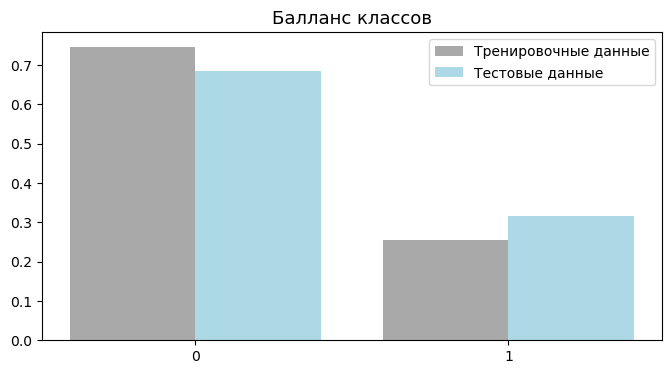

In [16]:
fig, ax = plt.subplots(figsize=(8, 4))

ord_train = ord_test = df_train['is_canceled'].value_counts().index 
absc_train = df_train['is_canceled'].value_counts().values/df_train.shape[0]
absc_test = df_test['is_canceled'].value_counts().values/df_test.shape[0]

ax.bar(ord_train-.2, absc_train, width = 0.4, color='darkgrey', label='Тренировочные данные')
ax.bar(ord_test+.2, absc_test, width = 0.4, color='lightblue', label='Тестовые данные')
ax.set_xticks([0, 1])

ax.set_title('Балланс классов', fontsize=13)
ax.legend()

plt.show()

<a id=class_ballance_conclusion> </a>

**Вывод:** после удаления дубликатов из тренировочных данных: соотношение отрицательного и положительного классов в тренировочных примерно `75:25`, в тестовых - примерно `67:32`. В тренировочных данных дисбаланс чуть больше.

<a id=4_2> </a>

### Количественные признаки

К количественным признакам можно отнести данные в столбцах `lead_time` (количество дней между датой бронирования и датой прибытия) и `days_in_waiting_list` (кол-во дней, которые заказ ожидал подтверждения). Кол-во уникальных значений довольно велико.

#### Столбец `lead_time`

Кол-во уникальных значений в тренировочных и тестовых данных

In [17]:
[df_train['lead_time'].nunique(), df_test['lead_time'].nunique() ]

[369, 368]

Посмотрим на распределение значений в столбцах `lead_time` для тренировочных и тестовых данных:

In [18]:
def distribution(df_1, df_2, column, n_bins):
    
    fig = plt.figure(figsize=(20,10))

    ax_0 = fig.add_subplot(1, 4, 1)
    ax_1 = fig.add_subplot(1, 4, 2)
    ax_2 = fig.add_subplot(2, 2, 2)
    ax_3 = fig.add_subplot(2, 2, 4)

    sns.boxplot(y=column, data=df_1, ax=ax_0, color='darkgrey')
    sns.boxplot(y=column, data=df_2, ax=ax_1, color='lightblue')
    ax_0.set_title('Тренировочные данные')
    ax_1.set_title('Тестовые данные')

    ax_2.hist(x=column, data=df_1, bins=n_bins, color='darkgrey')
    ax_3.hist(x=column, data=df_2, bins=n_bins, color='lightblue')
    ax_2.set_title(column + ' / Тренировочные данные')
    ax_3.set_title(column + ' / Тестовые данные')

    plt.show()

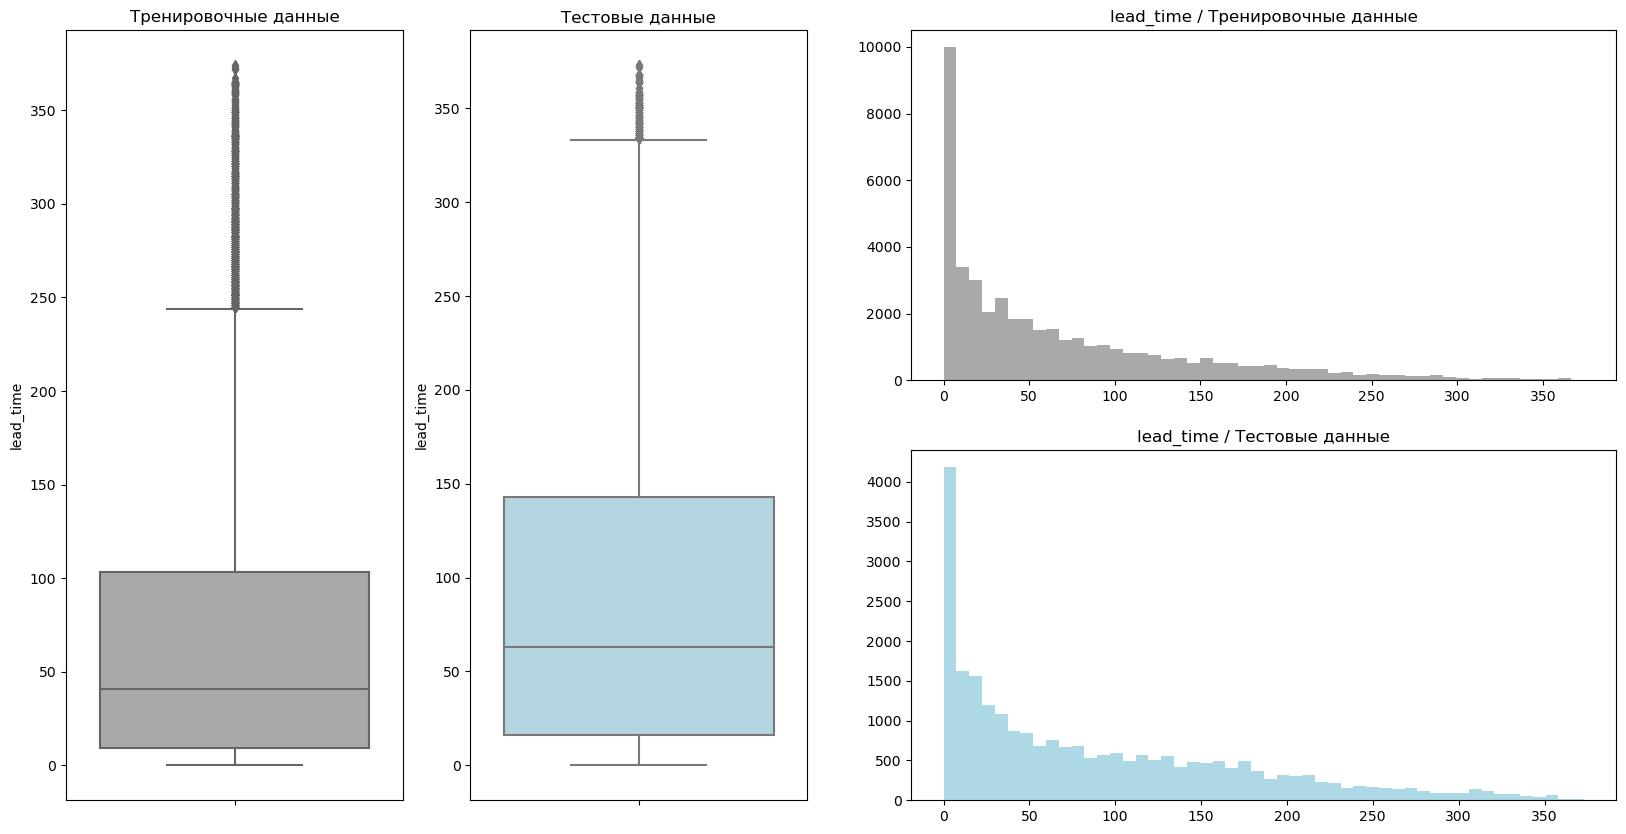

In [19]:
distribution(df_train, df_test, 'lead_time', 50)

In [20]:
df_train['lead_time'].describe().to_frame().join(
    df_test['lead_time'].describe().to_frame(),
    how='inner',
    lsuffix='_train',
    rsuffix='_test')

,lead_time_train,lead_time_test
count,43852.000,24695.000
mean,67.894,88.835
std,73.991,85.507
min,0.000,0.000
25%,9.000,16.000
50%,41.000,63.000
75%,103.000,143.000
max,374.000,373.000


Из распределений и из данных метода `.describe()` видно, что распределения **НЕ** очень похожы. Размах данных (1-3 квартили) отличается, медианы отличаются. В принципе, можно разбить на категории, опираясь на границы квартилей тренировочной выборки и погрешность будет незначительная, но лучше взять среднее для значений границ квартилей тренировочных и тестовых данных и разбить по этим средним значениям.

Переведем количественный признак в категориальный, используя метод `pd.cut()`, разбивая данные по средним значениям квартилей в тренировочных и тестовых данных:

In [21]:
n_bins = [-0.01, 7, 53, 123, 375]

label_list =['rapid', 'small', 'middle', 'long']

df_train.loc[:, 'lead_time_cat'] = pd.cut(df_train['lead_time'], bins=n_bins, labels=label_list)
df_test.loc[:, 'lead_time_cat'] = pd.cut(df_test['lead_time'], bins=n_bins, labels=label_list)

Кол-во значений в каждой из категорий:

In [22]:
df_train['lead_time_cat'].value_counts().to_frame().join(
    df_test['lead_time_cat'].value_counts().to_frame(),
    lsuffix='_train',
    rsuffix='_test')

,lead_time_cat_train,lead_time_cat_test
small,14773,7291
middle,10351,5744
rapid,9999,4187
long,8729,7473


Посмотрим на связь получившихся категорий и целевого признака

In [23]:
def cross_prob_bar(col_to_cross_name, ax):
    
    """строит диаграмму соотношения (вероятности) подтверждения/отказа
    для значений выбранного признака"""
    
    (pd.crosstab(df_train[col_to_cross_name], df_train['is_canceled'], margins=True)
    .drop('All', axis=0)
    .assign(norm_0 = lambda x: x[0]/x['All'])
    .assign(norm_1 = lambda x: x[1]/x['All'])[['norm_0', 'norm_1']]
    .rename(columns={'norm_0':'0', 'norm_1':'1'})
    .plot(kind='bar', ax=ax, stacked=True, color=['lightgreen', 'brown'], alpha=.75))

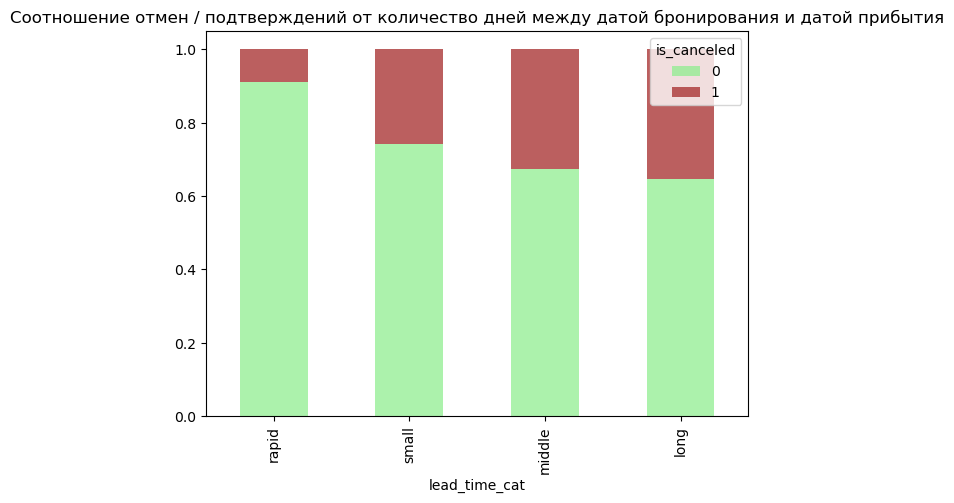

In [24]:
fig, ax = plt.subplots(figsize=(7, 5))

cross_prob_bar('lead_time_cat', ax)
ax.set_title('Соотношение отмен / подтверждений от количество дней между датой бронирования и датой прибытия')
plt.show()

**Вывод:** Количественный признак в столбце `lead_time` переведен в категориальный, базируясь на средних значениях квартилей. В дальнейшем к этому столбцу целесообразно применить OHE кодирование. Новый признак может служить хорошим фактором прогноза подтверждения/отказа бронирования.

#### Столбец `days_in_waiting_list`

Кол-во уникальных значений признака не столь велико - всего 97 и 75 уникальных значений в тренировочных и тестовых данных

In [25]:
[df_train['days_in_waiting_list'].nunique(), df_test['days_in_waiting_list'].nunique()]

[97, 75]

Из распределения данных (см. ниже) видим, что практически все заказы подтверждались сразу (ожидание = 0), но при этом есть довольно много выбросов (ожидание подтверждения заказа до 250+ дней)

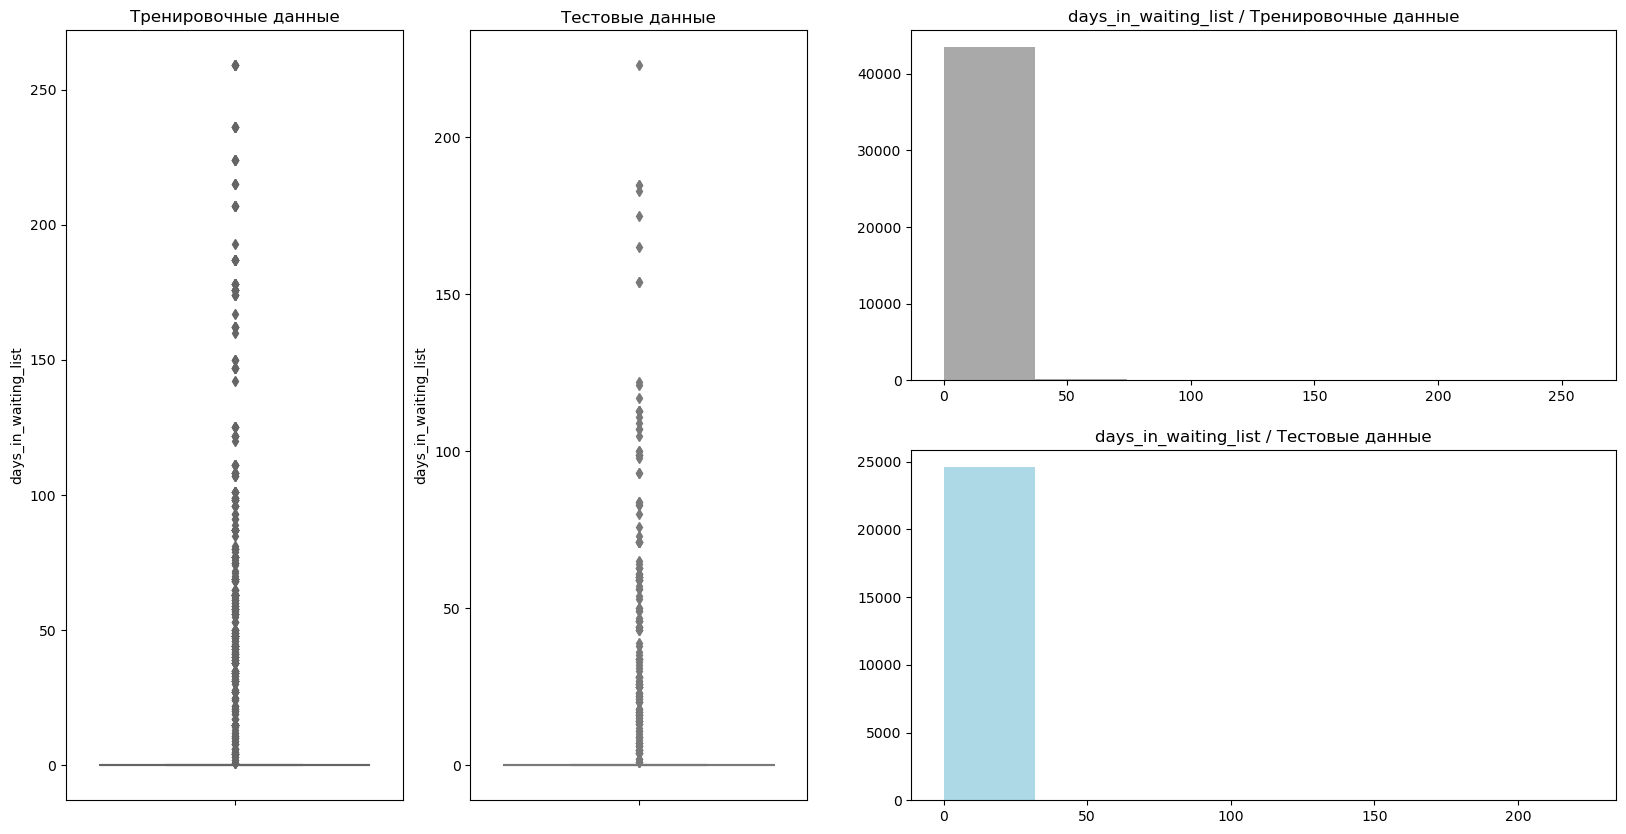

In [26]:
distribution(df_train, df_test, 'days_in_waiting_list', 7)

In [27]:
df_train['days_in_waiting_list'].describe().to_frame().join(
    df_test['days_in_waiting_list'].describe().to_frame(),
    how='inner',
    lsuffix='_train',
    rsuffix='_test')

,days_in_waiting_list_train,days_in_waiting_list_test
count,43852.000,24695.000
mean,0.821,0.341
std,9.902,5.404
min,0.000,0.000
25%,0.000,0.000
50%,0.000,0.000
75%,0.000,0.000
max,259.000,223.000


Посмотрим на распределение значений в столбце `days_in_waiting_list`, которые больше нуля:

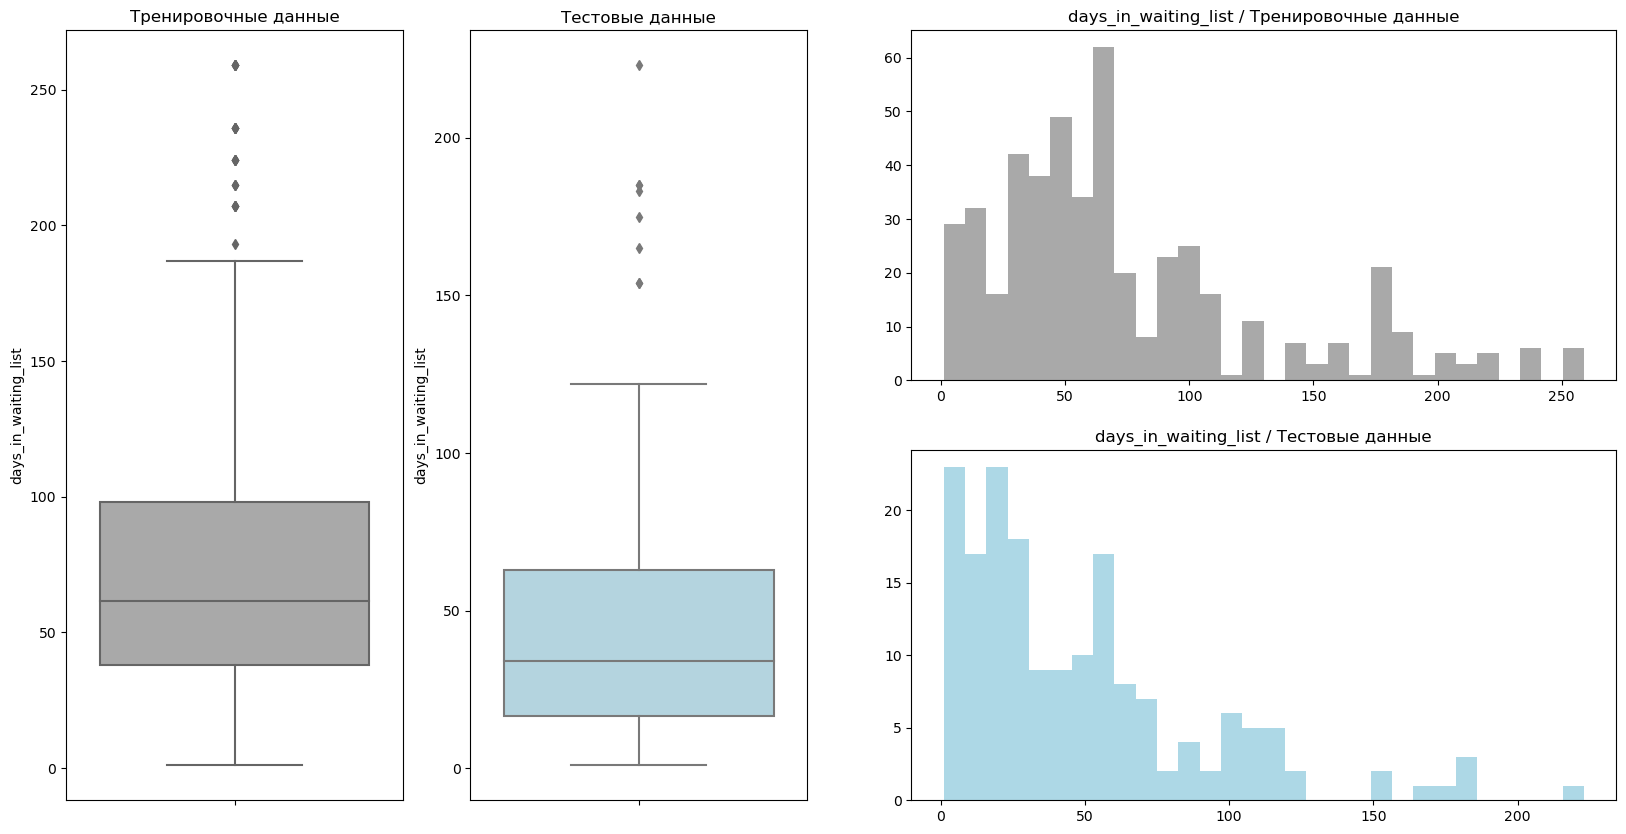

In [28]:
distribution(df_train[df_train['days_in_waiting_list']>0],
             df_test[df_test['days_in_waiting_list']>0],
             'days_in_waiting_list',
             30)

In [29]:
(
    df_train[df_train['days_in_waiting_list']>0]['days_in_waiting_list']
    .describe()
    .to_frame()
    .join(
        df_test[df_test['days_in_waiting_list']>0]['days_in_waiting_list']
        .describe()
        .to_frame(),
        how='inner',
        lsuffix='_train',
        rsuffix='_test'
    )
)

,days_in_waiting_list_train,days_in_waiting_list_test
count,480.000,175.000
mean,75.037,48.189
std,58.274,42.736
min,1.000,1.000
25%,38.000,16.500
50%,61.500,34.000
75%,98.000,63.000
max,259.000,223.000


Значений `> 0` довольно малое кол-во: 
- для тренировочных данных 480;
- для тестовых даных 177.

Параметры распределений этих значений (среднее, медиана, границы квартилей) заметно отличаются в тренировочных и тестовых данных. Если категоризировать данные по квартилям тренировочной выборки, то эти границы для тестовой выборки уходят уже в соседний квартиль. Назначим границы примерно ориентируясь по значениям границ квартилей.

- для значений от 0 до 3 введем категорию `rapid`
- для значений от 4 до 27 введем категорию `small`
- для значений от 28 до 47 введем категорию `middle`
- для значений от 48 до 81 введем категорию `long`
- для значений от 81 и выше введем категорию `x-long`

In [30]:
n_bins = [-.01, 14, 27, 47, 81, 260]

label_list = ['rapid', 'small', 'middle', 'long', 'x-long']

df_train.loc[:, 'days_in_waiting_list_cat'] = pd.cut(
    df_train['days_in_waiting_list'], bins=n_bins, labels=label_list
)
df_test.loc[:, 'days_in_waiting_list_cat'] = pd.cut(
    df_test['days_in_waiting_list'], bins=n_bins, labels=label_list
)

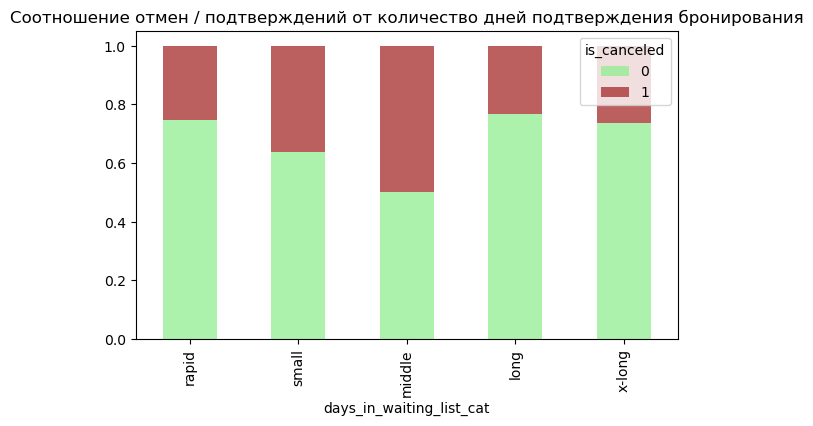

In [31]:
fig, ax = plt.subplots(figsize=(7, 4))
cross_prob_bar('days_in_waiting_list_cat', ax)
ax.set_title('Соотношение отмен / подтверждений от количество дней подтверждения бронирования')
plt.show()

Кол-во значений в каждой из категорий

In [32]:
df_train['days_in_waiting_list_cat'].value_counts().to_frame().join(
    df_test['days_in_waiting_list_cat'].value_counts().to_frame(),
    lsuffix='_train',
    rsuffix='_test')

,days_in_waiting_list_cat_train,days_in_waiting_list_cat_test
rapid,43411,24558
long,151,38
x-long,151,32
middle,92,30
small,47,37


**Вывод:** Количественный признак в столбце `days_in_waiting_list_cat` переведен в категориальный, базируясь на средних значениях квартилей. В дальнейшем к этому столбцу целесообразно применить OHE кодирование. Признак может служить хорошим фактором прогноза.

<a id=4_3> </a>

### Категориальные признаки

Называя признаки категориальными в данном случае подразумевается, что кол-во значений, которые принимают признаки, невелико.

#### Столбец `country`

Представляет интерес то, насколько значения в столбце `country` совпадают в тренировочной и тестовых выборках:

In [33]:
(
    df_train['country']
    .value_counts()
    .to_frame()
    .reset_index()
    .merge(
        df_test['country'].value_counts().to_frame().reset_index(),
        on='index',
        how='outer',
        indicator=True,
        suffixes=('_train', '_test')
    )
    .groupby(['_merge'])
    .count()
    .drop('index', axis=1)
)

,country_train,country_test
_merge,,
left_only,31,0
right_only,0,19
both,124,124


Из таблицы выше видно, что значения в столбце `country` совпадают по 124 позициям. Уникальные значения (содержатся только в тренировочных или только в тестовых данных) присутствуют как в тренировочных (31 значение), так и в тестовых (19 значений).

Распределения частот стран в тренировочных данных (значение в %, округление "вверх" методом `ceil`):

In [34]:
country_dstr = (
    df_train['country']
    .value_counts()
    .to_frame()
    .reset_index()
    .merge(
        df_test['country'].value_counts().to_frame().reset_index(),
        on='index',
        how='outer',
        suffixes=('_train_frq', '_test_frq')
    )
    .fillna(0)                      # значения которые были только в трейне или только в тесте заполняем 0
    .rename(columns={'index':'country'})
    .drop(columns=['country_test_frq'])
)

country_dstr['country_train_frq'] = (
    country_dstr['country_train_frq']/len(df_train)*100
).apply( lambda x: ceil(x))

In [35]:
display(country_dstr.head(7), country_dstr.tail(7))

,country,country_train_frq
0,PRT,33
1,FRA,12
2,GBR,10
3,ESP,9
4,DEU,7
5,ITA,5
6,IRL,3


,country,country_train_frq
167,MYT,0
168,TGO,0
169,MDG,0
170,ASM,0
171,FJI,0
172,UMI,0
173,FRO,0


In [36]:
country_dstr['country_train_frq'].nunique()

10

Можно сопоставить каждой стране значение её частоты в тренировочных данных. Это позволит перевести признак из категориального в числовой с значительно меньшей вариативностью значений (всего 10) и одновременно это позволит придать вес признаку в зависимости от частоты страны.

In [37]:
train_country_dict = dict(zip(country_dstr['country'], country_dstr['country_train_frq']))

df_train['country_frq'] = df_train['country'].map(train_country_dict)
df_test['country_frq'] = df_test['country'].map(train_country_dict)

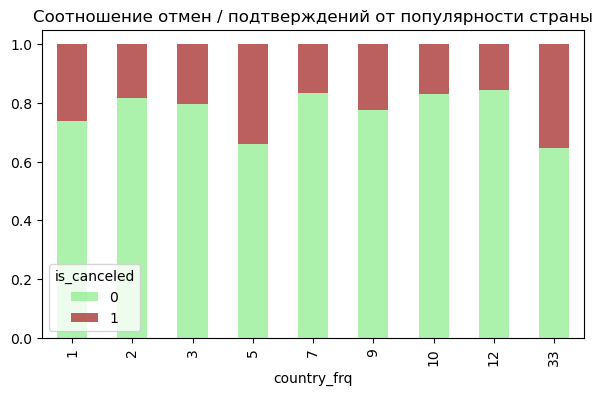

In [38]:
fig, ax = plt.subplots(figsize=(7, 4))
cross_prob_bar('country_frq', ax)
ax.set_title('Соотношение отмен / подтверждений от популярности страны')
plt.show()

**Вывод:** признак `country` преобразован в признак частоты (популярности) страны. В таком виде как фактор прогноза - намного лучше.

#### Столбцы  `arrival_date_year`, `arrival_date_month`, `arrival_date_day_of_month`, `arrival_date_week_number`

**Год `arrival_date_year`**

Как мы писали в [выводе 3.1](#intro_conclusion) столбец `arrival_date_year` в дальнейшем как признак использоваться не будет. Но он нам необходим, чтоб сгенерировать новый признак, который на мой взгляд будет хорошо коррелировать с целевым признаком. Создадим признак `arrival_date_day_of_week` - день недели.

In [39]:
month_dict = {'December':12,
              'January':1,
              'February':2,
              'March':3, 
              'April':4,
              'May':5,
              'June':6,
              'July':7,
              'August':8,
              'September':9,
              'October':10,
              'November':11}

cols=['arrival_date_year','arrival_date_month_num','arrival_date_day_of_month']

df_train = df_train.assign(
    arrival_date_month_num = lambda x: x['arrival_date_month'].map(month_dict)
)
df_test = df_test.assign(
    arrival_date_month_num = lambda x: x['arrival_date_month'].map(month_dict)
)

df_train['arrival_date_day_of_week'] = pd.to_datetime(
    df_train[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis=1)
).dt.dayofweek
df_test['arrival_date_day_of_week'] = pd.to_datetime(
    df_test[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis=1)
).dt.dayofweek

Теперь покажем на примере тренировочных данных, что день недели как фактор лучше, чем дата, месяц или номер недели

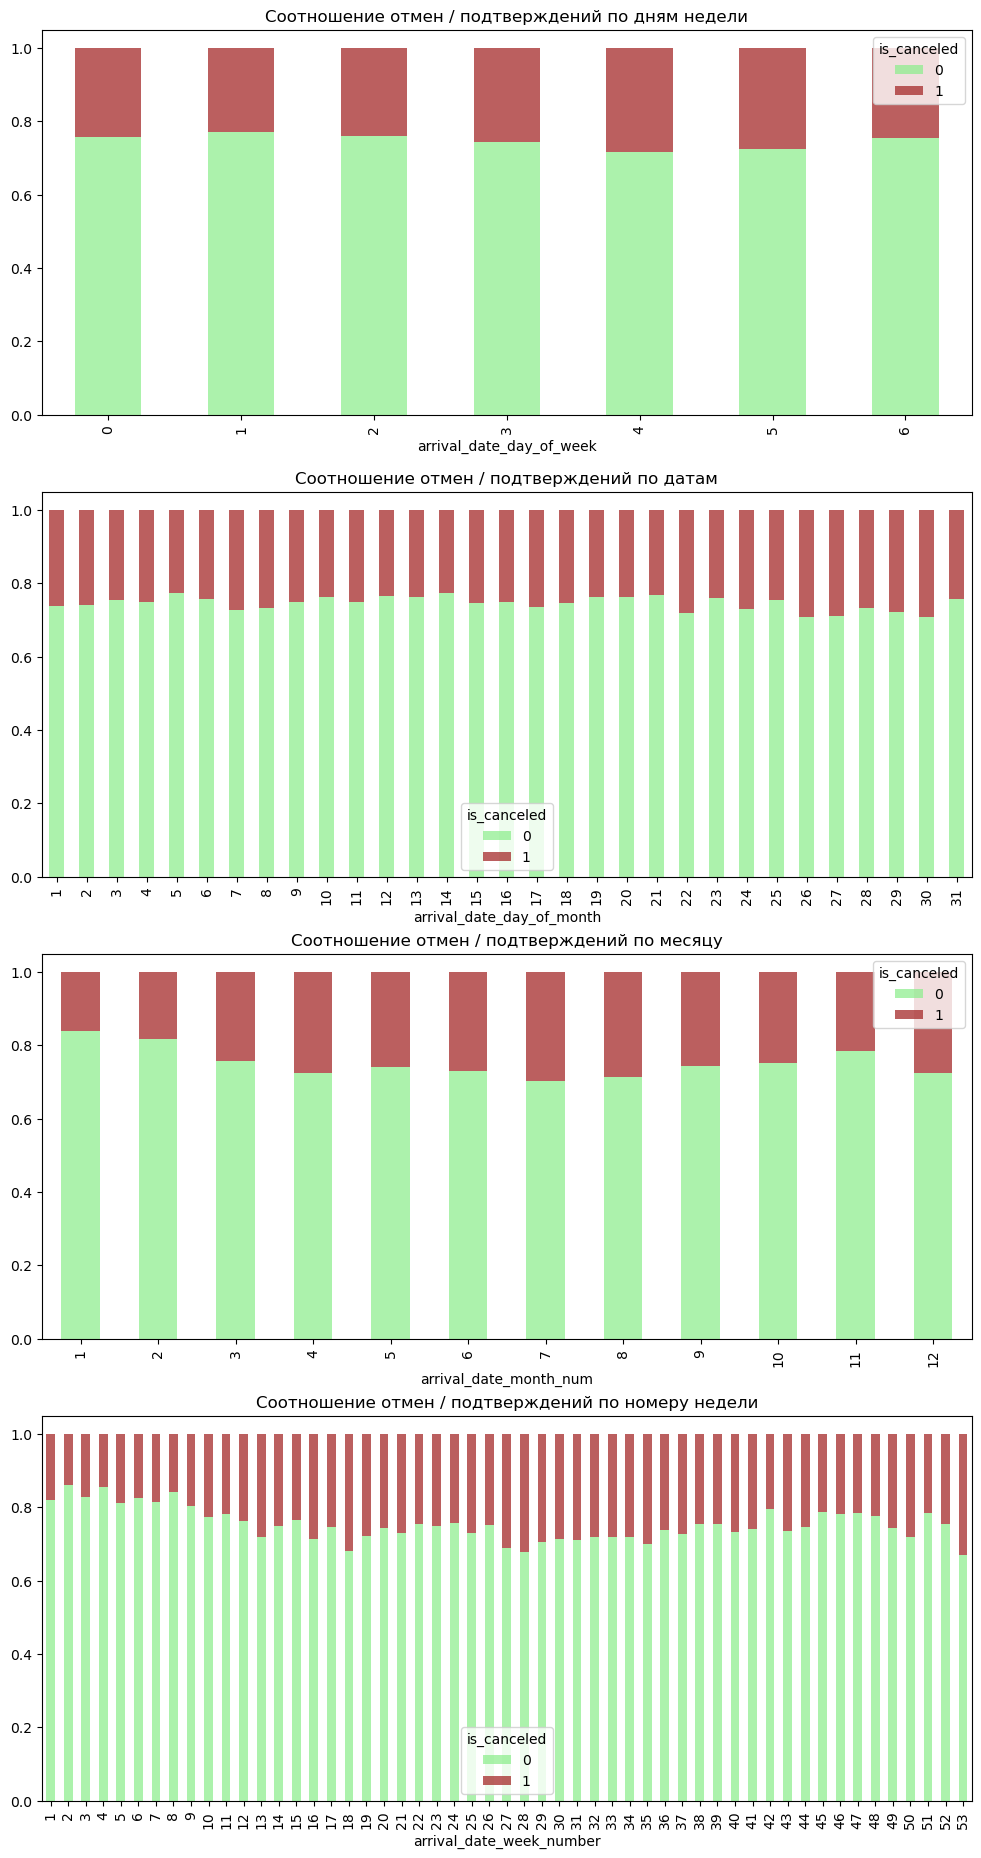

In [40]:
fig, ax = plt.subplots(4, 1, figsize=(12, 23))

cross_prob_bar('arrival_date_day_of_week', ax[0])
cross_prob_bar('arrival_date_day_of_month', ax[1])
cross_prob_bar('arrival_date_month_num', ax[2])
cross_prob_bar('arrival_date_week_number', ax[3])

ax[0].set_title('Соотношение отмен / подтверждений по дням недели')
ax[1].set_title('Соотношение отмен / подтверждений по датам')
ax[2].set_title('Соотношение отмен / подтверждений по месяцу')
ax[3].set_title('Соотношение отмен / подтверждений по номеру недели')

plt.show()

**Вывод:** как видно из диаграмм, день недели достаточно хорошо отражает вероятность подтверждения или отказа, но не является существенным прогнозирующим фактором.

**Месяц `arrival_date_month`**

Для столбца `arrival_date_month` в [выводе 3.1](#intro_conclusion) мы отметили то, что число уникальных значений отличается (12 и 8 соотв. для тренировочных и тестовых). Ниже выведем какие месяцы **не** входят тестовую выборку:

In [41]:
set(df_train['arrival_date_month'].unique()) - set(df_test['arrival_date_month'].unique())

{'December', 'November', 'October', 'September'}

Наиболее разумным выглядит подход сопоставления с месяцем признака, указывающего на сезон. Допустим: весна и осень - `normal`, зима - `low`, лето - `high` и далее применение OHE.

In [42]:
season_dict = {'December':'low',
               'January':'low',
               'February':'low',
               'March':'normal',
               'April':'normal',
               'May':'normal',
               'June':'high',
               'July':'high',
               'August':'high',
               'September':'normal',
               'October':'normal',
               'November':'normal'}

df_train = df_train.assign(
    season = lambda x: x['arrival_date_month'].map(season_dict)
)
df_test = df_test.assign(
    season = lambda x: x['arrival_date_month'].map(season_dict)
)

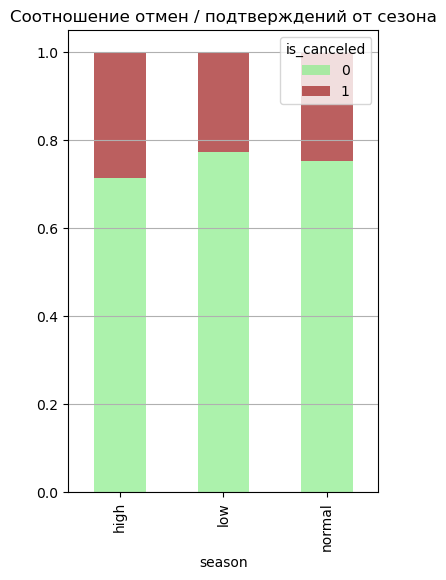

In [43]:
fig, ax = plt.subplots(figsize=(4, 6))

cross_prob_bar('season', ax)
ax.set_title('Соотношение отмен / подтверждений от сезона')
ax.grid(axis='y')
plt.show()

**Вывод:** переход от месяца к сезону позволит нивелировать разницу в значених в тренировочных и тестовых данных и новый признак как фактор более четко указывает на вероятность подтверждения/отмены, хотя судя по диаграмее вероятность не сильно дифференцирована, поэтому это скорее слабый прогнозирующий фактор.

**Неделя `arrival_date_week_number`**

Для столбца `arrival_date_week_number` в [выводе 3.1](#intro_conclusion) мы отметили то, что число уникальных значений отличается (53 и 35 соотв. для тренировочных и тестовых). Ниже выведем какие номера недель **не** входят тестовую выборку:

In [44]:
set(df_train['arrival_date_week_number'].unique()) - set(df_test['arrival_date_week_number'].unique())

{36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53}

Номер недели и признак `season`, который мы создали выше, скорее всего скоррелированы, поэтому признак `arrival_date_week_number` не будем использовать для модели

#### Столбцы  `babies`, `children`, `adults`

**Количество младенцев `babies`**

Очевидно, что кол-во младенцев 9 и 10 в тренировочных данных - это аномалия. Эти строки удаляем.

In [45]:
df_train['babies'].value_counts()

0.000     43403
1.000       444
2.000         3
10.000        1
9.000         1
Name: babies, dtype: int64

In [46]:
df_test['babies'].value_counts()

0.000    24521
1.000      170
2.000        4
Name: babies, dtype: int64

In [47]:
df_train = df_train.drop( df_train[ (df_train['babies'] == 10) | (df_train['babies'] == 9) ].index )

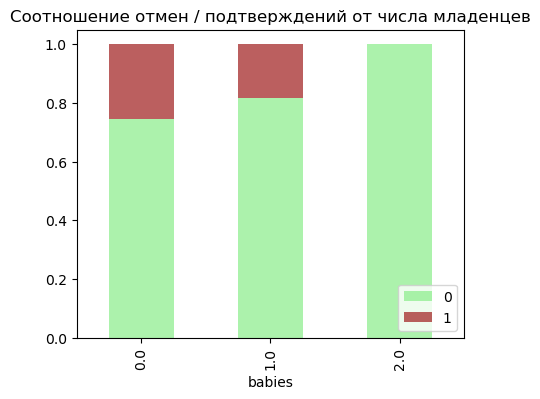

In [48]:
fig, ax = plt.subplots(figsize=(5, 4))

cross_prob_bar('babies', ax)
ax.set_title('Соотношение отмен / подтверждений от числа младенцев')
ax.legend(loc='lower right')
plt.show()

**Вывод:** убрали аномальные значения. Как фактор прогноза `babies` хороший признак.

**Кол-во детей от 3 до 14 лет `children`**

In [49]:
df_train['children'].value_counts()

0.000    40469
1.000     2060
2.000     1305
3.000       16
Name: children, dtype: int64

In [50]:
df_test['children'].value_counts()

0.000    22727
1.000     1322
2.000      641
3.000        5
Name: children, dtype: int64

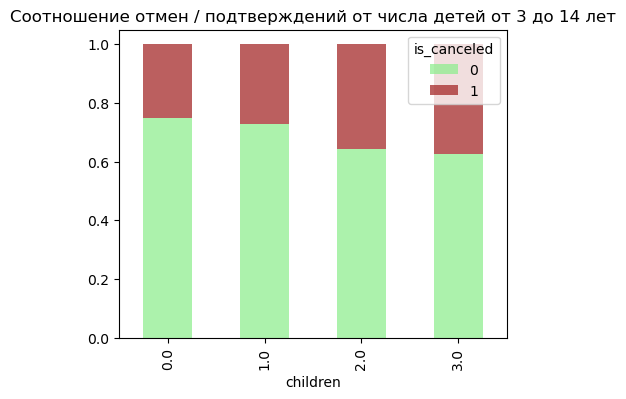

In [51]:
fig, ax = plt.subplots(figsize=(5, 4))

cross_prob_bar('children', ax)
ax.set_title('Соотношение отмен / подтверждений от числа детей от 3 до 14 лет')
plt.show()

**Вывод:** с точки зрения прогнозирующего фактора - хороший признак. Чем больше детей, тем выше вероятность отмены.

**Количество взрослых постояльцев `adults`**

In [52]:
df_train['adults'].value_counts()

2.000    32298
1.000     8687
3.000     2688
0.000      164
4.000       13
Name: adults, dtype: int64

In [53]:
df_test['adults'].value_counts()

2.000    18536
1.000     4378
3.000     1708
0.000       65
4.000        8
Name: adults, dtype: int64

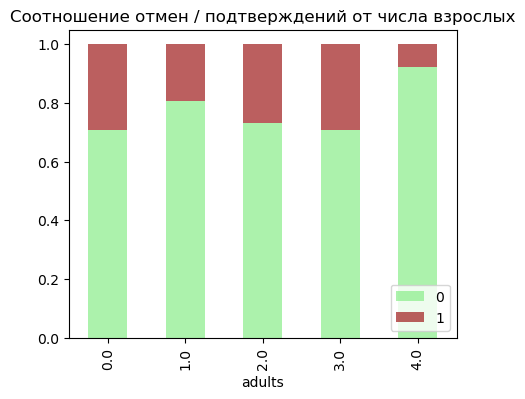

In [54]:
fig, ax = plt.subplots(figsize=(5, 4))

cross_prob_bar('adults', ax)
ax.set_title('Соотношение отмен / подтверждений от числа взрослых')
ax.legend(loc='lower right')
plt.show()

**Вывод:** признак `adults` - хороший прогнозирующий фактор!

#### Столбцы `previous_cancellations`, `previous_bookings_not_canceled`, `booking_changes`, `is_repeated_guest`

**Количество отменённых заказов у клиента `previous_cancellations`**

Большие значения (например, 20 и более) в тренировочных данных выглядят удивительно... Однако, кол-во таких значений сопоставимо и даже превышает некоторые значения, которые меньше.

In [55]:
df_train['previous_cancellations'].value_counts()

0     42699
1       995
2        52
3        47
11       27
5        13
4         5
13        3
24        2
6         2
26        1
25        1
14        1
19        1
21        1
Name: previous_cancellations, dtype: int64

In [56]:
df_test['previous_cancellations'].value_counts()

0    24472
1      162
2       29
6       15
4       10
3        6
5        1
Name: previous_cancellations, dtype: int64

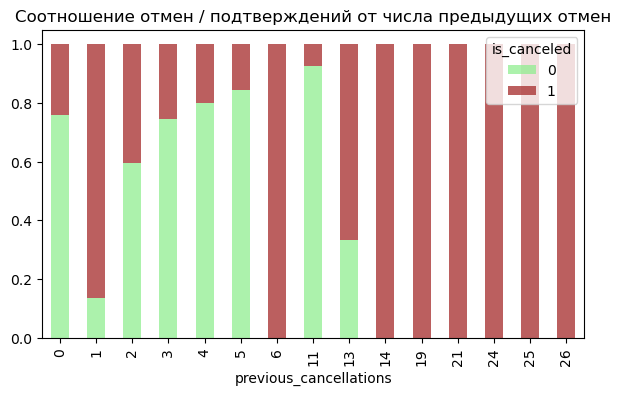

In [57]:
fig, ax = plt.subplots(figsize=(7, 4))

cross_prob_bar('previous_cancellations', ax)
ax.set_title('Соотношение отмен / подтверждений от числа предыдущих отмен')

plt.show()

**Вывод:** признак `previous_cancellations` должен быть хорошим прогнозирующим фактором. Учитывая, что подавляющее число значений это `1` или `0`, а по этим значениям очень хорошая дифференциация  вероятности отмены/подтверждения.

**Количество подтверждённых заказов у клиента `previous_bookings_not_canceled`**

Значения в тренировочных данных и в тестовых данных сопоставимы как по значениям так и по частоте. Уникальных значений достаточно много (несколько десятков), по частоте преобладает `0`, далее значения от `1` до `4` с значениями в несколько сотен, далее значения от `5` до `12` с частотами несколько десятков и потом большое кол-во значений с частотами менее 10.

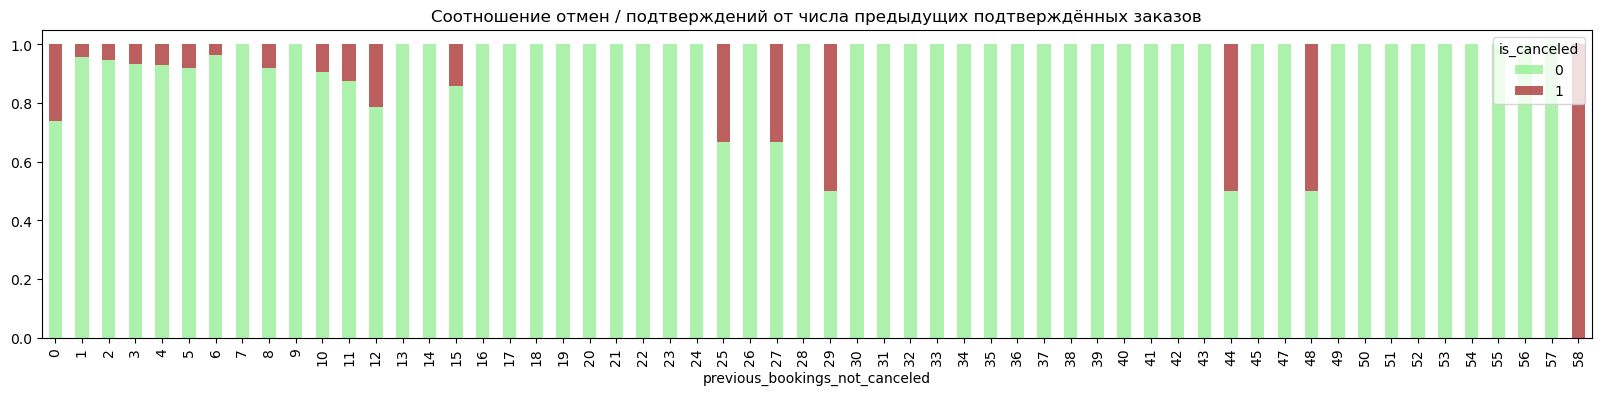

In [58]:
fig, ax = plt.subplots(figsize=(20, 4))

cross_prob_bar('previous_bookings_not_canceled', ax)
ax.set_title('Соотношение отмен / подтверждений от числа предыдущих подтверждённых заказов')

plt.show()

**Вывод:** признак `previous_bookings_not_canceled` как прогнозирующий фактор - слабый.

**Количество изменений параметров заказа `booking_changes`**

Значения и их частоты в тренировочных и тестовых данных выглядят относительно симметрично.

In [59]:
df_train['booking_changes'].value_counts()

0     36265
1      5389
2      1578
3       379
4       138
5        41
6        18
7        18
8         7
9         5
13        4
10        2
14        2
15        2
16        1
17        1
Name: booking_changes, dtype: int64

In [60]:
df_test['booking_changes'].value_counts()

0     20614
1      2596
2      1069
3       253
4       109
5        27
6        15
7         5
18        1
15        1
16        1
14        1
8         1
11        1
10        1
Name: booking_changes, dtype: int64

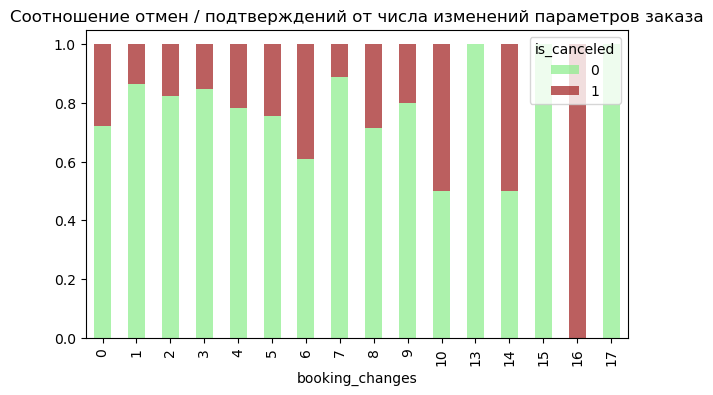

In [61]:
fig, ax = plt.subplots(figsize=(7, 4))

cross_prob_bar('booking_changes', ax)
ax.set_title('Соотношение отмен / подтверждений от числа изменений параметров заказа')

plt.show()

**Вывод:** признак `booking_changes` слабый критерий прогноза. Можно оставить как есть, далее при масштабировании значения "сожмутся".

**Признак того, что гость бронирует номер второй раз `is_repeated_guest`**

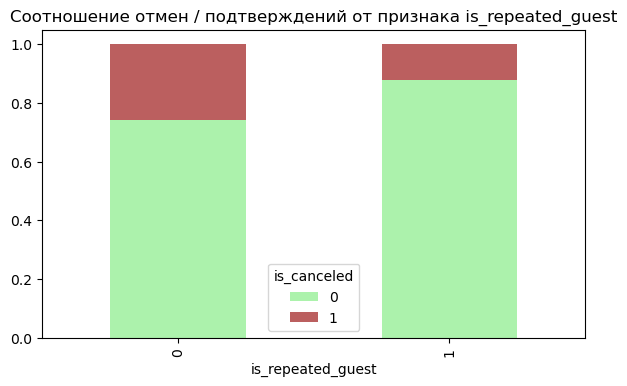

In [62]:
fig, ax = plt.subplots(figsize=(7, 4))

cross_prob_bar('is_repeated_guest', ax)
ax.set_title('Соотношение отмен / подтверждений от признака is_repeated_guest')

plt.show()

**Вывод:** признак `is_repeated_guest` как прогнозирующий фактор - хороший признак.

#### Столбцы `required_car_parking_spaces`, `reserved_room_type`, `meal`, `stays_in_weekend_nights`, `stays_in_week_nights`, `total_nights`

**Необходимость места для автомобиля `required_car_parking_spaces`**

Значение `8` в тестовых данных выглядит выбросом...но это же тестовые данные :)

In [63]:
df_train['required_car_parking_spaces'].value_counts()

0    40251
1     3587
2       11
3        1
Name: required_car_parking_spaces, dtype: int64

In [64]:
df_test['required_car_parking_spaces'].value_counts()

0    23246
1     1440
2        6
8        2
3        1
Name: required_car_parking_spaces, dtype: int64

In [65]:
df_test[df_test['required_car_parking_spaces'] == 8]

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,lead_time_cat,days_in_waiting_list_cat,country_frq,arrival_date_month_num,arrival_date_day_of_week,season
2107,17717,0,26.000,2017,March,11,14,0,5,2.000,0.000,0.000,HB,AUT,Corporate,1,0,2,E,1,0,Transient-Party,8,1,5,small,rapid,2,3,1,normal
2108,17718,0,138.000,2017,March,12,19,2,2,2.000,0.000,0.000,HB,AUT,Corporate,1,0,2,E,1,122,Transient-Party,8,0,4,long,x-long,2,3,6,normal


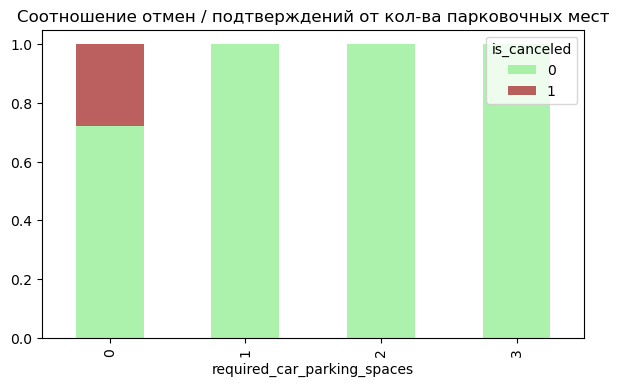

In [66]:
fig, ax = plt.subplots(figsize=(7, 4))

cross_prob_bar('required_car_parking_spaces', ax)
ax.set_title('Соотношение отмен / подтверждений от кол-ва парковочных мест')

plt.show()

**Вывод:** признак `required_car_parking_spaces` - судя по соотношению с целевым ведет себя как бинарный признак. Как фактор прогноза - достаточно хорош.

**Категория номера `reserved_room_type`**

Посмотрим на уникальные значения в столбце `reserved_room_typ` в тренировочных и тестовых данных:

In [67]:
( df_train['reserved_room_type'].unique(), df_test['reserved_room_type'].unique() )

(array(['A               ', 'C               ', 'D               ',
        'E               ', 'G               ', 'F               ',
        'B               '], dtype=object),
 array(['A               ', 'E               ', 'G               ',
        'D               ', 'F               ', 'C               ',
        'B               '], dtype=object))

Уберем пробелы, посмотрим на взаимосвязь значения `reserved_room_type` с целевым признаком.

In [68]:
df_train['reserved_room_type'] = df_train['reserved_room_type'].apply(lambda x: x.strip())
df_test['reserved_room_type'] = df_test['reserved_room_type'].apply(lambda x: x.strip())

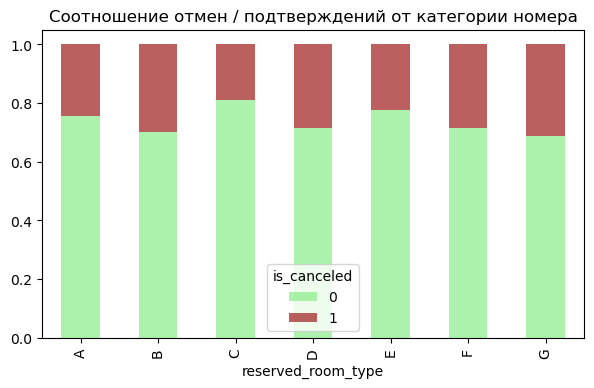

In [69]:
fig, ax = plt.subplots(figsize=(7, 4))

cross_prob_bar('reserved_room_type', ax)
ax.set_title('Соотношение отмен / подтверждений от категории номера')

plt.show()

**Вывод:** признак `reserved_room_type` хороший критерий прогноза.

**Тип питания `meal`**

Посмотрим на уникальные значения:

In [70]:
( df_train['meal'].unique(), df_test['meal'].unique() )

(array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC'],
       dtype=object),
 array(['BB       ', 'HB       ', 'SC', 'FB       ', 'SC       '],
       dtype=object))

Очистим от пробелов, посмотрим на взаимосвязь с целевым признаком

In [71]:
df_train['meal'] = df_train['meal'].apply(lambda x: x.strip())
df_test['meal'] = df_test['meal'].apply(lambda x: x.strip())

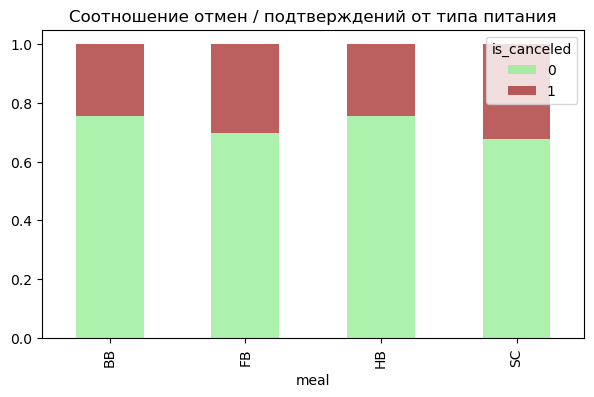

In [72]:
fig, ax = plt.subplots(figsize=(7, 4))

cross_prob_bar('meal', ax)
ax.set_title('Соотношение отмен / подтверждений от типа питания')

plt.show()

**Вывод:** признак `meal` - судя по соотношению с целевым ведет себя как бинарный признак (BB, HB и FB, SC - попарно практически одинаковое соотношение). Как фактор прогноза - хороший признак.

**Кол-во ночей в будни `stays_in_week_nights`, кол-во ночей в выходные `stays_in_weekend_nights`, общее кол-во ночей `total_nights`**

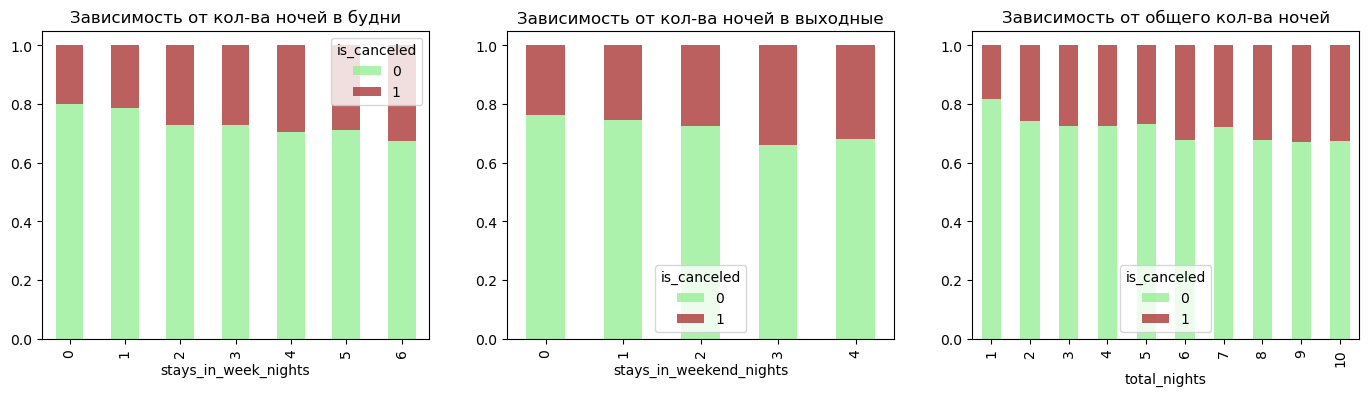

In [73]:
fig, ax = plt.subplots(1, 3, figsize=(17, 4))

cross_prob_bar('stays_in_week_nights', ax[0])
ax[0].set_title('Зависимость от кол-ва ночей в будни')

cross_prob_bar('stays_in_weekend_nights', ax[1])
ax[1].set_title('Зависимость от кол-ва ночей в выходные')

cross_prob_bar('total_nights', ax[2])
ax[2].set_title('Зависимость от общего кол-ва ночей')

plt.show()

**Вывод:** признаки `total_nights`, `stays_in_week_nights` и `stays_in_week_nights` вероятно скоррелированы. Проверим на данных матрицы корреляции.

#### Столбцы `distriburion_channel`, `customer_type`, `total_of_special_requests`

**Канал дистрибуции заказа `distribution_channel`**

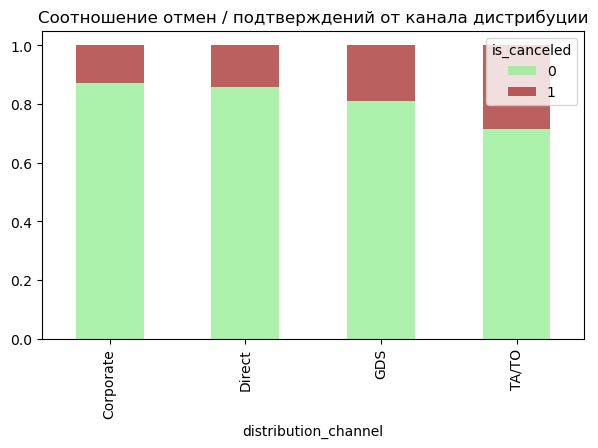

In [74]:
fig, ax = plt.subplots(figsize=(7, 4))

cross_prob_bar('distribution_channel', ax)
ax.set_title('Соотношение отмен / подтверждений от канала дистрибуции')

plt.show()

**Вывод** признак `distribution_channel` достаточно хороший критерий прогноза.

**Тип заказчика `customer_type`**

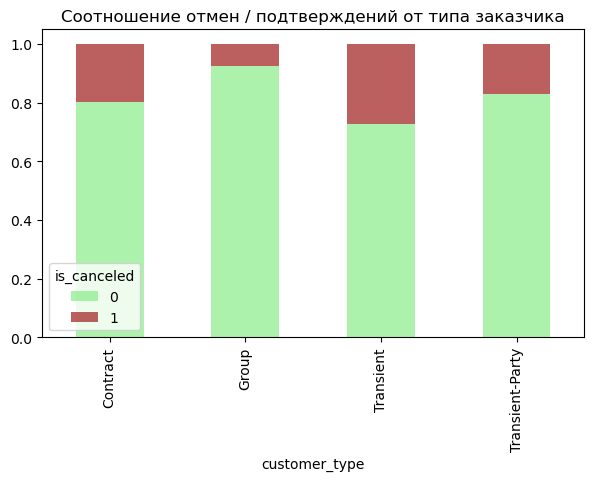

In [75]:
fig, ax = plt.subplots(figsize=(7, 4))

cross_prob_bar('customer_type', ax)
ax.set_title('Соотношение отмен / подтверждений от типа заказчика')

plt.show()

**Вывод:** признак `customer_type` отличный прогнозирующий фактор!

 **Количество специальных отметок `total_of_special_requests`**

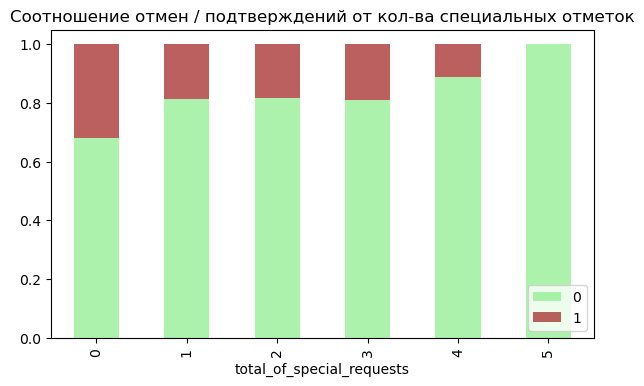

In [76]:
fig, ax = plt.subplots(figsize=(7, 4))

cross_prob_bar('total_of_special_requests', ax)
ax.set_title('Соотношение отмен / подтверждений от кол-ва специальных отметок')
ax.legend(loc='lower right')
plt.show()

**Вывод:** признак `total_of_special_requests` хороший фактор прогноза.

### Применение OHE кодирования

Для ОНЕ кодирования выбираем следующие столбцы:
- `lead_time_cat`
- `days_in_waiting_list_cat`
- `season`
- `meal`
- `distribution_channel`
- `reserved_room_type`
- `customer_type`

Столбцы, которые нам не потребуются, удалим (список `col_to_del`).

In [77]:
col_to_OHE = ['lead_time_cat',
              'days_in_waiting_list_cat',
              'meal',
              'season',
              'distribution_channel',
              'reserved_room_type',
              'customer_type']

col_to_del = ['id',
              'lead_time',
              'arrival_date_year',
              'arrival_date_month',
              'arrival_date_week_number',
              'arrival_date_day_of_month',
              'country',
              'days_in_waiting_list',
              'arrival_date_month_num']

In [78]:
df_train_OHE = (
    pd.get_dummies(df_train, columns=col_to_OHE, drop_first=True)
    .rename(
        columns={'distribution_channel_TA/TO': 'distribution_channel_tato',
                 'customer_type_Transient-Party':'customer_type_transient_party'
                }
    ).drop(columns=col_to_del)
)

df_test_OHE = (
    pd.get_dummies(df_test, columns=col_to_OHE, drop_first=True)
    .rename(
        columns={'distribution_channel_TA/TO': 'distribution_channel_tato',
                 'customer_type_Transient-Party':'customer_type_transient_party'}
    ).drop(columns=col_to_del)
)

df_train_OHE.columns = df_train_OHE.columns.str.lower()
df_test_OHE.columns = df_test_OHE.columns.str.lower()

In [79]:
df_train_OHE[df_train_OHE.duplicated()].groupby('is_canceled').agg('count').iloc[:, 2]

is_canceled
0    5344
1    1627
Name: adults, dtype: int64

In [80]:
df_train_OHE = df_train_OHE.drop_duplicates().reset_index(drop=True)

### Матрица корреляции

In [81]:
def corr_matrix_heatmap(data, title, res = '.1f'):
    fig, ax = plt.subplots(figsize=(12, 9))
    sns.heatmap(data,
                annot=True,
                fmt=res,
                center=0.3,
                linewidths=.6,
                annot_kws={'fontsize': 7},
                ax=ax
               )
    ax.set_title(title, fontsize=16)
    plt.show()

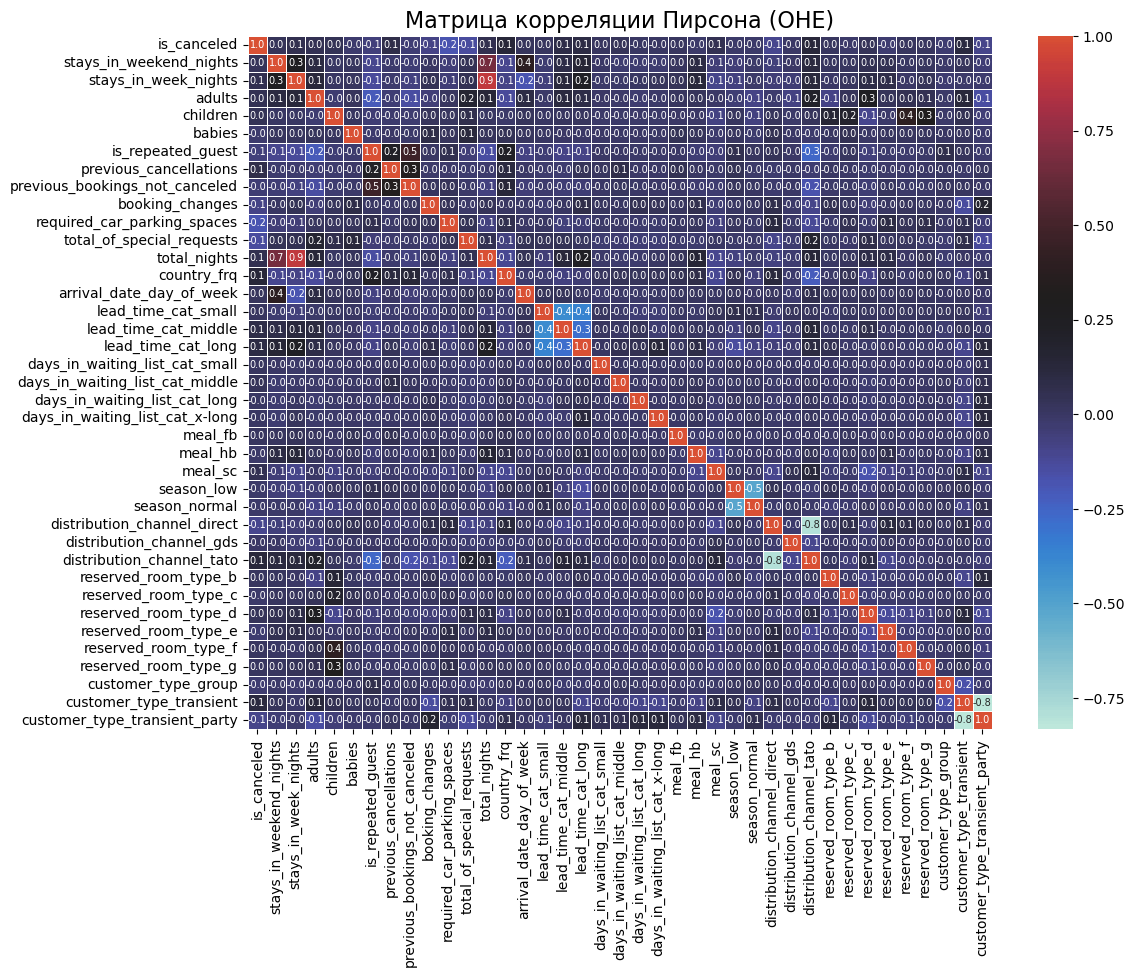

In [82]:
corr_matrix_heatmap(df_train_OHE.corr(), 'Матрица корреляции Пирсона (OHE)')

Заметные корреляции:
- признаки `total_nights` и `stays_in_week_nights` (**0.9**)
- признаки `distribution_channel_tato` и `distribution_channel_direct` (**-0.8**)
- признаки `customer_type_transient` и `customer_type_transient_party` (**-0.8**)

In [83]:
df_train_OHE['distribution_channel_tato'].sum(), df_train_OHE['distribution_channel_direct'].sum()

(29438, 5156)

In [84]:
df_train_OHE['customer_type_transient'].sum(), df_train_OHE['customer_type_transient_party'].sum()

(29330, 5584)

Оставляем:
- признак `total_nights` 
- признак `distribution_channel_tato`
- признаки `customer_type_transient`

In [85]:
df_train_OHE = df_train_OHE.drop(['stays_in_week_nights',
                                  'distribution_channel_direct',
                                  'customer_type_transient_party'],
                                 axis=1)

df_test_OHE = df_test_OHE.drop(['stays_in_week_nights',
                                'distribution_channel_direct',
                                'customer_type_transient_party'],
                               axis=1)

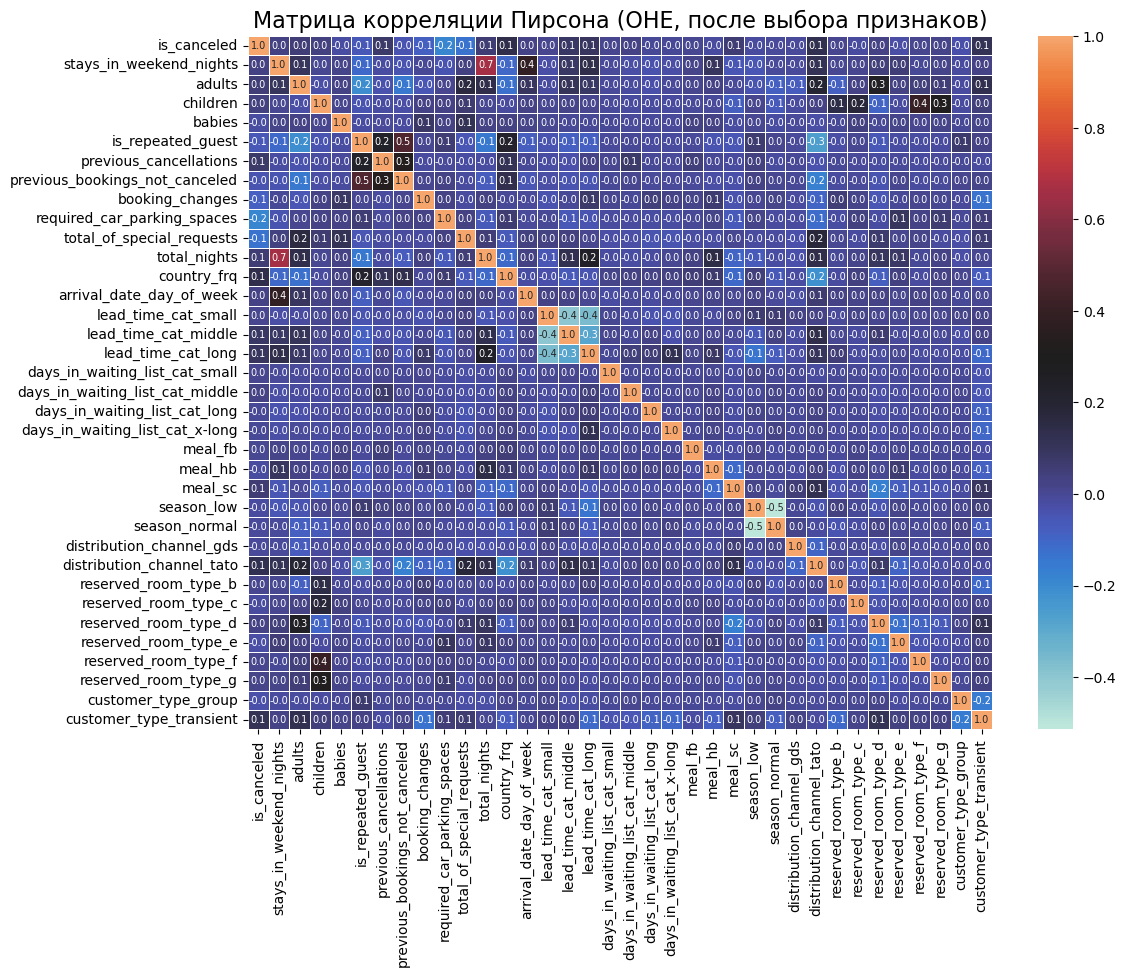

In [86]:
corr_matrix_heatmap(df_train_OHE.corr(), 'Матрица корреляции Пирсона (OHE, после выбора признаков)')

### Масштабирование признаков

Поскольку предполагается кросс-валидация, то разделять тренировочную выборку не нужно. Разделим только признаки и целевой признак, затем признаки отмасштабируем с помощью класса `StandardScaler()`

In [87]:
X_train = df_train_OHE.drop('is_canceled', axis=1)
Y_train = df_train_OHE['is_canceled']

X_test = df_test_OHE.drop('is_canceled', axis=1)
Y_test = df_test_OHE['is_canceled']

In [88]:
col_2scale = ['adults',
              'children',
              'babies',
              'is_repeated_guest',
              'previous_cancellations',
              'previous_bookings_not_canceled',
              'booking_changes',
              'required_car_parking_spaces',
              'total_of_special_requests',
              'total_nights',
              'stays_in_weekend_nights',
              'country_frq',
              'arrival_date_day_of_week']

In [89]:
# масштабирование проводим только для столбцов из 'col_2scale'

col = col_2scale
scaler = StandardScaler()

scaler.fit(X_train[col])
X_train[col] = scaler.transform(X_train[col])
X_test[col] = scaler.transform(X_test[col])

Проверяем, что все признаки в тренировочной и тестовой выборках отмасштабированы:

In [90]:
display(X_train[col_2scale].sample(3, random_state=RND_ST))
display(X_test[col_2scale].sample(3, random_state=RND_ST))

,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,required_car_parking_spaces,total_of_special_requests,total_nights,stays_in_weekend_nights,country_frq,arrival_date_day_of_week
33334,0.259,-0.295,-0.110,-0.192,-0.092,-0.103,-0.395,-0.318,1.551,-0.153,0.090,-0.745,0.497
25657,0.259,-0.295,-0.110,-0.192,-0.092,-0.103,-0.395,-0.318,0.342,-0.153,0.090,-0.198,0.497
12567,0.259,-0.295,-0.110,-0.192,-0.092,-0.103,-0.395,-0.318,-0.867,-0.153,-1.052,-0.745,-0.001


,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,required_car_parking_spaces,total_of_special_requests,total_nights,stays_in_weekend_nights,country_frq,arrival_date_day_of_week
16345,-1.679,-0.295,-0.110,-0.192,-0.092,-0.103,-0.395,-0.318,-0.867,-1.202,-1.052,-1.058,-0.001
12308,0.259,-0.295,-0.110,-0.192,-0.092,-0.103,2.358,-0.318,1.551,1.945,1.232,-0.198,-0.499
23448,0.259,-0.295,-0.110,-0.192,-0.092,-0.103,-0.395,-0.318,0.342,-0.153,0.090,-0.902,0.497


### Вывод

По итогам предобработки и иследовательского анализа:

- Удалены дубликаты;
- Проверен балланс классов в тренировочной и тестовой выборках. Соотношение отрицательного и положительного классов в тренировочных данных примерно `75:25`, в тестовых - примерно `67:32`;
- Количественные признаки в столбцах `lead_time` (количество дней между датой бронирования и датой прибытия) и `days_in_waiting_list` (кол-во дней, которые заказ ожидал подтверждения) переведены в категориальные методом биннинга данных;
- Создан новый признак - день недели `arrival_date_day_of_week`. Показана корреляция нового признака и целевого признака;
- Категориальный признак `arrival_date_month` заменен более компактным и универсальрным признаком `season`;
- Категориальные признаки `babies`,  `previous_cancellations`,  `previous_bookings_not_canceled`,  `booking_changes`,  `required_car_parking_spaces` исследованы на выбросы, из критичных выбросов - удалены 2 наблюдения в столбце `babies` с значениями 9 и 10;
- Из признаков `stays_in_week_nights`, `stays_in_weekend_nights`, `total_nights` оставлены только 2 последних;
- Применено ОНЕ кодирование для категориальных признаков, ненужные столбцы удалены;
- Произведен выбор признаков по данным матрицы кореляции Пирсона;
- Проведено масштабирование признаков **(кроме признаков прошедших ОНЕ кодирования)** для тренировочных и тестовых данных классом `StandardScaler()`;
- Сформириованы датасеты тренировочных признаков `X_train` и тренировочного целевого признака `Y_train`; датасеты тестовых признаков `X_train` и тестового целевого признака `Y_train`.

## Формулировка ML-задачи на основе бизнес-задачи

<a id=business_params> </a>
### Расчет бизнесс-показателей до внедрения депозитов

Расчет прибыли отеля до внедрения системы депозитов проведем на тестовых данных `df_test`. После внедрения системы депозитов (на основе предсказаний модели) мы сможем провести новый расчет и сравнить разницу бизнесс-показателей до и после внедрения системы депозитов.

Для расчета нам потребуются не все столбцы. Оставим только указанные:
- `is_canceled`
- `total_nights`
- `reserved_room_type`
- `season`

In [91]:
df_test_prof_calc = df_test[['is_canceled',
                             'total_nights',
                             'reserved_room_type',
                             'season']]

Добавим данные о стоимости типа номера, стоимости разового обслуживания и сезонных коэффициентах. Стоимость номера добавим в колонку `room_charges`, затраты на разовое обслуживание `service_fee`, сезонный коэффициент `multiplicator`.

In [92]:
charges_dict = dict(
    zip(
        sorted(list(df_test_prof_calc['reserved_room_type'].unique())),
        [1000, 800, 600, 550, 500, 450, 350]
    )
)
service_fee_dict = dict(
    zip(
        sorted(list(df_test_prof_calc['reserved_room_type'].unique())),
        [400, 350, 350, 150, 150, 150, 150]
    )
)
multiplicator_dict = {'high': 1.4,
                      'normal': 1.2,
                      'low': 1}

columns_2add_list = [['room_charges', 'reserved_room_type', charges_dict],
                     ['service_fee', 'reserved_room_type', service_fee_dict],
                     ['multiplicator', 'season', multiplicator_dict]]


for col_new, col_base, dct in columns_2add_list:
    df_test_prof_calc[col_new] = df_test_prof_calc[col_base].map(dct)

In [93]:
df_test_prof_calc.sample(10, random_state=RND_ST)

,is_canceled,total_nights,reserved_room_type,season,room_charges,service_fee,multiplicator
16345,0,1,A,normal,1000,400,1.200
12308,1,7,A,high,1000,400,1.400
23448,0,3,A,high,1000,400,1.400
4421,0,6,D,normal,550,150,1.200
1456,1,1,D,high,550,150,1.400
18837,0,1,E,normal,500,150,1.200
17395,0,3,A,normal,1000,400,1.200
4258,0,3,C,normal,600,350,1.200
6863,1,3,A,low,1000,400,1.000
2564,0,1,A,low,1000,400,1.000


Все строки, где в `is_canceled = 1`, это - отмененные заказы. По этим заказам отель не получил выручку, но понес однократные `n_of_service = 1` затраты  в размере разового обслуживания `service_fee` для подготовки номера.

Для строк, где `is_canceled = 0`, нужно рассчитать выручку и затраты. Выручка составляет `total_nights` х `room_charges` х `multiplicator`. Затраты сотавляют `service_fee` х `n_of_service`, где число обслуживаний `n_of_service` равно 
1 + ( **ceil**(`total_nights`/ 2) - 1).

Т.о. совокупные затраты складываются из затрат на подготовку номера и затрат на периодическую уборку (раз в 2 дня). Если число ночей чётное, то последняя уборка будет совпадеть с подготовкой номера для следующего клиента и не должна быть отнесена на затраты предыдущего. Если число ночей нечётное, то мы округляем в бОльшую сторону до целого и также отнимаем единицу.

In [94]:
df_test_prof_calc['n_of_service'] = df_test_prof_calc[
    df_test_prof_calc['is_canceled'] == 0
]['total_nights'].apply( lambda x: 1+(ceil(x/2)-1))

df_test_prof_calc = df_test_prof_calc.fillna(1)

df_test_prof_calc = df_test_prof_calc.assign(
    expencies = lambda x: x['service_fee']*x['n_of_service']
).assign(
    revenue = lambda x: x['total_nights']
    * x['room_charges']
    * x['multiplicator']
    * (1-x['is_canceled'])
)

In [95]:
df_test_prof_calc

,is_canceled,total_nights,reserved_room_type,season,room_charges,service_fee,multiplicator,n_of_service,expencies,revenue
0,1,1,A,low,1000,400,1.000,1.000,400.000,0.000
1,1,4,A,low,1000,400,1.000,1.000,400.000,0.000
2,1,4,A,low,1000,400,1.000,1.000,400.000,0.000
3,1,7,A,low,1000,400,1.000,1.000,400.000,0.000
4,1,7,A,low,1000,400,1.000,1.000,400.000,0.000
...,...,...,...,...,...,...,...,...,...,...
24690,0,6,A,high,1000,400,1.400,3.000,1200.000,8400.000
24691,0,7,A,high,1000,400,1.400,4.000,1600.000,9800.000
24692,0,7,A,high,1000,400,1.400,4.000,1600.000,9800.000
24693,0,7,D,high,550,150,1.400,4.000,600.000,5390.000


In [96]:
rev_wo_deposit = df_test_prof_calc['revenue'].sum()
exp_wo_deposite = df_test_prof_calc['expencies'].sum()
profit_wo_deposit = rev_wo_deposit - exp_wo_deposite

print('Выручка до внедрения депозита:', '\t\t', '{:,}'.format(rev_wo_deposit).replace(',', ' '))
print('Затраты до внедрения депозита:', '\t\t', '{:,}'.format(exp_wo_deposite).replace(',', ' '))
print('Валовая прибыль до внедрения депозита:  ', '{:,}'.format(profit_wo_deposit).replace(',', ' '))

Выручка до внедрения депозита: 		 55 587 150.0
Затраты до внедрения депозита: 		 12 595 300.0
Валовая прибыль до внедрения депозита:   42 991 850.0


### Формулировка ML-задачи

Необходимо определять только тех, кто с большой долей вероятности отменит бронирование и предлагать им депозит, чтоб "захеджировать" затраты на разовое обслуживание. Одновременно, бизнес не должен предлагать более жесткие условия в виде депозита благонадежным клиентам, чтоб те не отказались от заказа. В данном случае с точки зрения ML терминологии мы видим, что нужно  максимизировать **Recall** (чем больше мы выявим положительный класс - тем меньше будут убытки) и максимизировать **Precision** (не обременять благонадежных клиентов, генерируя **FP**). Для достижения этих целей нам подойдет метрика **F1**.

Кроме этого, по условиям бизнеса бюджет на разработку модели 400 000 должен компенсироваться увеличением выручки в размере превышающем объем затрат. Тоесть после внедрения модели показатель выручки должен увеличится более чем на 400 000, чем до внедрения модели.

### Вывод

Бизнесс показатели до внедрения депозитов:
- Выручка до внедрения депозита: 		   55 587 150.0
- Затраты до внедрения депозита: 		   12 595 300.0
- Валовая прибыль до внедрения депозита:   42 991 850.0

В качестве метрики оценки модели выбираем **F1**.
После выбора модели и подбора гиперпараметров модели необходимо проверить, чтоб выручка увеличилась более, чем на 400 000.

## Разработка ML модели

### Выбор модели методом кросс-валидации на тренировочных данных

Рассмотрим классификаторы:
- Логистическую регрессию
- Дерево решений
- Случайный лес


Для каждой из моделей будем вычислять метрику **F1** с помощью `cross_val_score`, разбив тренировочные данные генератором `KFold` на N_FLDS наборов. Выведем среднее значение **F1** для кросс-валидации на тренировочных данных .

Оформим все действия в виде функции `model_casting`, которая будет выводить пошаговые результаты и вернёт итоговые данные в виде датафрейма. Затем выведем итоговый датафрейм, отсортировав по убыванию значения **F1**.

In [97]:
#sorted(SCORERS.keys())

In [98]:
kf = KFold(n_splits=N_FLDS, random_state=RND_ST, shuffle=True)

models_wght = []
models_wght.append(('LogisticRegression', LogisticRegression(multi_class = 'ovr',
                                                             solver='liblinear',
                                                             class_weight='balanced',
                                                             n_jobs=-1,
                                                             random_state=RND_ST)))
models_wght.append(('      DecisionTree', DecisionTreeClassifier(class_weight='balanced',
                                                                 random_state=RND_ST)))
models_wght.append(('      RandomForest', RandomForestClassifier(class_weight='balanced_subsample',
                                                                 random_state=RND_ST)))

In [99]:
def model_casting(models, x_train, y_train, folds=kf):
    
    names = []
    train_cv_scores = []
    for name, model in models:    
        names.append(name)
        cv_scores = cross_val_score(model, x_train, y_train, cv=folds, scoring='f1')
        train_cv_scores.append(cv_scores.mean())
        report = (f"{name}: f1_mean = {round(cv_scores.mean(), 4)}")
        print(report)
       
    scores_chart_df = pd.DataFrame(data = {'name': names, 'f1_mean': train_cv_scores})
    
    return scores_chart_df

In [100]:
%%time

weighted_chart = model_casting(models_wght, X_train, Y_train)
display(weighted_chart.sort_values(by='f1_mean', ascending=False).reset_index(drop=True))

LogisticRegression: f1_mean = 0.5641
      DecisionTree: f1_mean = 0.4489
      RandomForest: f1_mean = 0.4683


,name,f1_mean
0,LogisticRegression,0.564
1,RandomForest,0.468
2,DecisionTree,0.449


CPU times: total: 22.2 s
Wall time: 22.2 s


**Вывод:** Для дальнейшей работы забираем модели `LogisticRegression` и `RandomForest`

### Подбор гиперпараметров

Прежде, чем тестировать модели, найдем для моделей оптимальные гиперпараметры, применив класс `GridSearchCV()`

In [101]:
%%time

rf_model_prms = {
    'max_depth': list(range(22, 27, 2)),
    'n_estimators': list(range(150, 301, 50)),
    'min_samples_leaf': list(range(3, 5)),
    'min_samples_split': list(range(6, 9))
}

rf_model = RandomForestClassifier(class_weight='balanced_subsample',
                                  random_state=RND_ST)
rf = GridSearchCV(rf_model, rf_model_prms, scoring='f1', cv=kf, n_jobs=-1)
rf.fit(X_train, Y_train)

print(f'Оптимальное значение depth: {rf.best_params_["max_depth"]}')
print(f'Оптимальное значение n_estimators: {rf.best_params_["n_estimators"]}')
print(f'Оптимальное значение min_samples_leaf: {rf.best_params_["min_samples_leaf"]}')
print(f'Оптимальное значение min_samples_split: {rf.best_params_["min_samples_split"]}')
print(f'Лучшее значение f1: {rf.best_score_} \n')

Оптимальное значение depth: 24
Оптимальное значение n_estimators: 200
Оптимальное значение min_samples_leaf: 3
Оптимальное значение min_samples_split: 8
Лучшее значение f1: 0.6102633547380004 

CPU times: total: 13.4 s
Wall time: 12min 54s


In [102]:
%%time

lr_model_prms = {
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'penalty': [None, 'elasticnet', 'l1', 'l2',]
}

lr_model = LogisticRegression(multi_class='ovr',
                              class_weight='balanced',
                              random_state=RND_ST)
lr = GridSearchCV(lr_model, lr_model_prms, scoring='f1', cv=kf, n_jobs=-1)
lr.fit(X_train, Y_train)

print(f'Оптимальное значение solver: {lr.best_params_["solver"]}')
print(f'Оптимальное значение penalty: {lr.best_params_["penalty"]}')
print(f'Лучшее значение f1: {lr.best_score_} \n')

Оптимальное значение solver: liblinear
Оптимальное значение penalty: l1
Лучшее значение f1: 0.5644893248104554 

CPU times: total: 6.72 s
Wall time: 24.5 s


Сформируем список `best_models`, возьмем гиперпараметры из результатов работы класса `GridSearchCV()`.

In [103]:
best_models = []
best_models.append(['RandomForest',
                    RandomForestClassifier(
                        max_depth = rf.best_params_["max_depth"],
                        n_estimators = rf.best_params_["n_estimators"],
                        min_samples_leaf = rf.best_params_["min_samples_leaf"],
                        min_samples_split = rf.best_params_["min_samples_split"],
                        class_weight = 'balanced_subsample',
                        n_jobs=-1,
                        random_state = RND_ST)]
                  )
best_models.append(['LogisticRegression',
                    LogisticRegression(
                        solver = lr.best_params_["solver"],
                        penalty = lr.best_params_["penalty"],
                        multi_class='ovr',
                        class_weight = 'balanced',
                        n_jobs=-1,
                        random_state=RND_ST)]
                  )

Подберем оптимальные пороги (thresholds)

In [104]:
def threshold_tuning(name, model, x_trn=X_train, y_trn=Y_train, kfold=kf):
    thrsh_list = []
    f1_list = []
    for i, (trn_index, val_index) in enumerate(kfold.split(x_trn)):
        
        fch_trn = x_trn.iloc[trn_index, :]
        trgt_trn = y_trn[trn_index]
        fch_val = x_trn.iloc[val_index, :]
        trgt_val = y_trn[val_index]
        
        model.fit(fch_trn, trgt_trn)
        probs = model.predict_proba(fch_val)
        precision, recall, thresholds = precision_recall_curve(trgt_val, probs[:, 1], pos_label=1)
        f1_metric = (2*precision*recall/(precision+recall))
        thrsh_list.append(thresholds[np.argmax(f1_metric)])
        f1_list.append(max(f1_metric))
    
    mean_thrsh = np.mean(thrsh_list)
    mean_f1 = np.mean(f1_list)
    
    print(name, '\t', 'средний оптимальный порог', "{:.4f}".format(mean_thrsh),
          '\t', 'cреднее значение f1', "{:.4f}".format(mean_f1))
    return mean_thrsh

In [105]:
rf_opt_thrsh = threshold_tuning(best_models[0][0], best_models[0][1])
lr_opt_thrsh = threshold_tuning(best_models[1][0], best_models[1][1])

RandomForest 	 средний оптимальный порог 0.4890 	 cреднее значение f1 0.6122
LogisticRegression 	 средний оптимальный порог 0.5395 	 cреднее значение f1 0.5704


In [106]:
best_models[0].append(rf_opt_thrsh)
best_models[1].append(lr_opt_thrsh)

### Тестирование моделей

Создаем функцию, которая проведет проверку моделей на тестовых данных и рассчитает метрики.

In [107]:
def model_testing(models_list, x_train, y_train, x_test, y_test):
    
    df_report = pd.DataFrame()
    list_y_test_predict = []
    list_confusion_matrix = []
    
    for name, best_model, thrsh in models_list:
        
        best_model.fit(x_train, y_train)
        proba = best_model.predict_proba(x_test)
        predict = np.where(proba[:, 1] <= thrsh, 0, 1) 
        list_y_test_predict.append([name, predict])
        list_confusion_matrix.append([name, confusion_matrix(y_test, predict)])
        
        accuracy = accuracy_score(y_test, predict)
        precision = precision_score(y_test, predict)
        recall = recall_score(y_test, predict)
        f1 = f1_score(y_test, predict)
        auc_roc = roc_auc_score(y_test, proba[:, 1])
        
        df_report[name] = (pd.Series(data = [f1, precision, recall, accuracy, auc_roc],
                                     index = ['f1', 'Precision', 'Recall', 'Аccuracy', 'AUC-ROC']))

        print('Тестирование модели', name, 'завершено.')
                
    display(df_report.T.sort_values(by='f1', ascending=False))
    
    return df_report, list_confusion_matrix, list_y_test_predict

Замерим метрики моделей на тестовых данных, выведем значения метрик в таблие и матрицы ошибок для каждой модели:

In [108]:
pd.set_option('display.float_format', '{:.4f}'.format)

Тестирование модели RandomForest завершено.
Тестирование модели LogisticRegression завершено.


,f1,Precision,Recall,Аccuracy,AUC-ROC
LogisticRegression,0.5710,0.4883,0.6873,0.6744,0.7553
RandomForest,0.5630,0.5252,0.6067,0.7031,0.7639


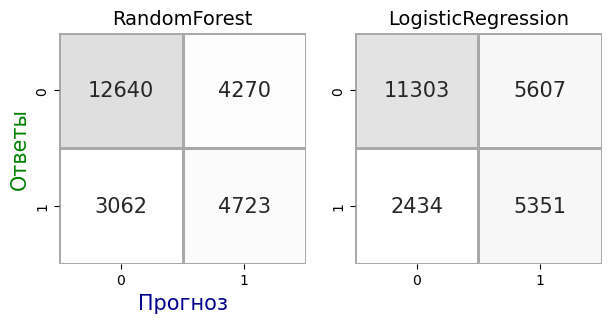

In [109]:
df_test_report, lst_test_conf_mtrx, lst_y_test_pred = model_testing(best_models, X_train, Y_train, X_test, Y_test)

fig, ax = plt.subplots(1, 2, figsize=(7,3))

for n in range(2):
    sns.heatmap(lst_test_conf_mtrx[n][1], ax=ax[n],
                annot=True, fmt='n', annot_kws={'fontsize':15},
                cbar=False, linewidths=1, linecolor='darkgrey', cmap='Greys', center=25000)
    ax[n].set_title(lst_test_conf_mtrx[n][0], fontsize=14)

ax[0].set_xlabel('Прогноз', fontsize=15, color='darkblue')
ax[0].set_ylabel('Ответы', fontsize=15, color='green')

plt.show()

По ключевому показателю `F1` лучшая модель -  **логистическая регрессия**.

### Расчет бизнес показателей с учетом применения моделей

Мы уже [считали](#business_params) бизнесс показатели, необходимые данные у нас есть в переменной `df_test_prof_calc`. Дополним эти данные столбцами с предсказаниями наших моделей, имена столбцов сделаем такими же как имена моделей.

In [110]:
for name, data in lst_y_test_pred:
    df_test_prof_calc[name.strip()] = pd.Series(data)

In [111]:
df_test_prof_calc[['is_canceled',
                   'LogisticRegression',
                   'RandomForest']
                 ].sample(5, random_state=RND_ST +7)

,is_canceled,LogisticRegression,RandomForest
12185,1,0,1
19684,0,1,0
8639,1,1,0
8775,1,1,1
17953,0,0,0


Как будем проводить оценку:

- Вариант TP: модель дала верный прогноз, тогда однократные затраты на подготовку номера остаются, но в выручке появляется 80% депозит от стоимости номера (согласно категории и мультипликатору сезона) и однократных затрат на уборку.
- Вариант FP: модель ошибочно предсказала отказ, но событие не произошло. Депозит в этом случае будет зачтён при окончательной оплате. С точки зрения итоговых затрат и выручки - ничего не изменится.
- Вариант TN: никаких изменений в расчете выручки и затрат.
- Вариант FN: никаких изменений в расчете выручки и затарт.

т.о. нас интересуют только TP и дополнительная выручка для этих случаев. Для каждой модели мы должны найти TP и посчитать доп. выручку для этих случаев. Та модель, у которой доп. выручка будет максимальной и будет лучшей. При этом нам нужно выполнить условие, чтоб значение доп. выручки было более 400 000.

In [112]:
df_test_prof_calc_w_deposit = (
    df_test_prof_calc
    .assign(
        LR_add_rev = lambda x: x['is_canceled']
        * x['LogisticRegression']
        * DEPOSITE_RATE
        * (x['room_charges']*x['multiplicator'] + x['service_fee'])
    )
    .assign(
        RF_add_rev = lambda x: x['is_canceled']
        * x['RandomForest']
        * DEPOSITE_RATE
        * (x['room_charges']*x['multiplicator'] + x['service_fee'])
    )
)

In [113]:
df_test_prof_calc_w_deposit[
    ['is_canceled',
     'LogisticRegression',
     'RandomForest',
     'LR_add_rev',
     'RF_add_rev']
].sample(7, random_state=RND_ST +7)

,is_canceled,LogisticRegression,RandomForest,LR_add_rev,RF_add_rev
12185,1,0,1,0.0000,1440.0000
19684,0,1,0,0.0000,0.0000
8639,1,1,0,1280.0000,0.0000
8775,1,1,1,552.0000,552.0000
17953,0,0,0,0.0000,0.0000
23206,0,0,0,0.0000,0.0000
5288,0,0,1,0.0000,0.0000


In [114]:
for name, col in [
    ['LogisticRegression', 'LR_add_rev'],
    ['RandomForest', 'RF_add_rev']
]:
    print('Дополнительная выручка для модели',
          name, 'составила',
          '{:,}'.format(
              df_test_prof_calc_w_deposit[col].sum()
          ).replace(',', ' ')
         )

Дополнительная выручка для модели LogisticRegression составила 5 802 680.0
Дополнительная выручка для модели RandomForest составила 5 139 656.0


### Вывод

Лучшая модель по бизнесс-метрике *максимальная дополнительная выручка* - модель **логистическая регрессия** с макс. показателем дополнительной выручки `5.8 млн.`, что значительно превышает обозначенные затраты в 400 000 на разработку.

## Портрет «ненадёжного» клиента

Для выявления наиболее характерных признаков "ненадежного" клиента обратимся к разделам [4.2](#4_2) и [4.3](#4_3)

По разделу **4.2**:

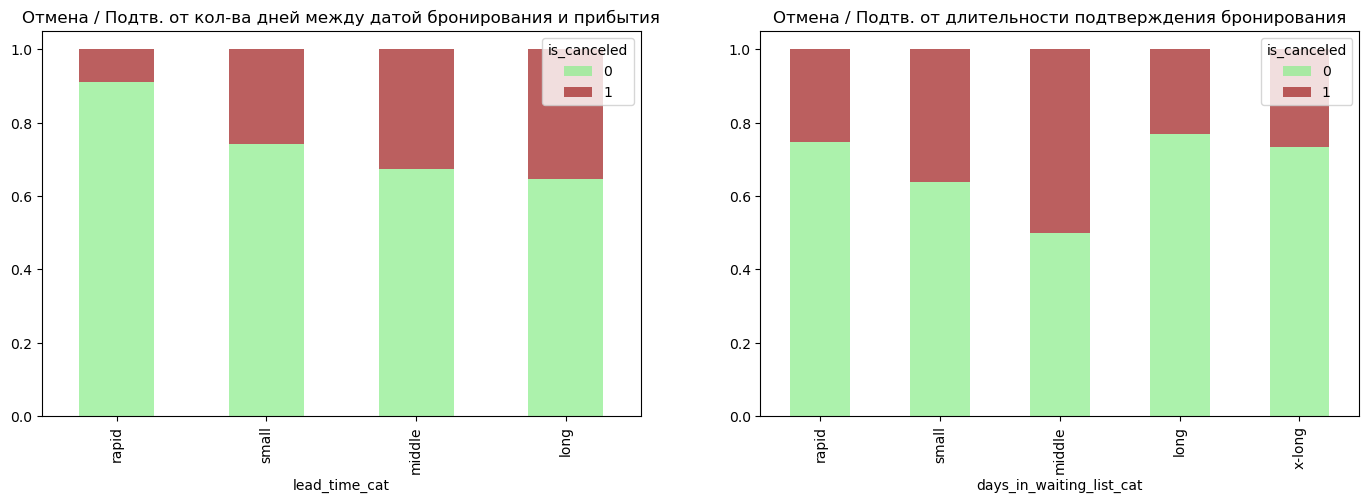

In [115]:
fig, ax = plt.subplots(1, 2, figsize=(17, 5))

cross_prob_bar('lead_time_cat', ax[0])
ax[0].set_title('Отмена / Подтв. от кол-ва дней между датой бронирования и прибытия')

cross_prob_bar('days_in_waiting_list_cat', ax[1])
ax[1].set_title('Отмена / Подтв. от длительности подтверждения бронирования')

plt.show()

ЗАКЛЮЧЕНИЕ **№1**:
- чем больше время между датой бронирования и датой прибытия - тем больше вероятность отказа
- зона наиболее высокого риска отказа (`middle`), когда подтверждение о бронировании получено в диапазоне  от 28 до 47 дней.

По разделу **4.3**:

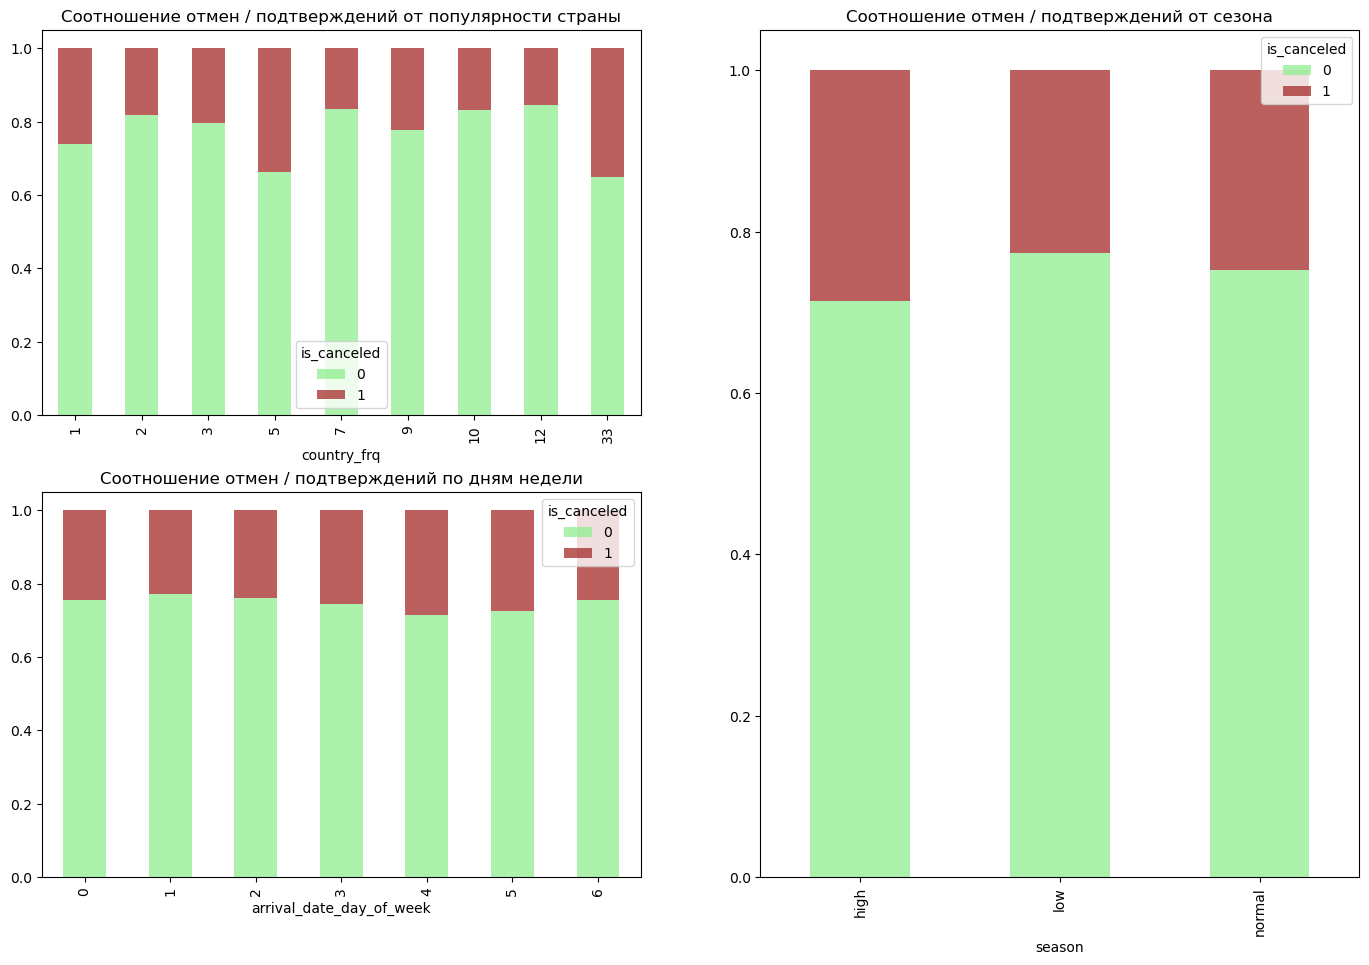

In [116]:
fig  = plt.figure(figsize=(17, 11))

ax_1 = fig.add_subplot(2, 2, 1)
ax_2 = fig.add_subplot(2, 2, 3)
ax_3 = fig.add_subplot(1, 2, 2)

cross_prob_bar('country_frq', ax_1)
cross_prob_bar('arrival_date_day_of_week', ax_2)
cross_prob_bar('season', ax_3)

ax_1.set_title('Соотношение отмен / подтверждений от популярности страны')
ax_2.set_title('Соотношение отмен / подтверждений по дням недели')
ax_3.set_title('Соотношение отмен / подтверждений от сезона')

plt.show()

ЗАКЛЮЧЕНИЕ **№2**:
- гость из популярной страны 
- прибытие назначено на пятницу
- высокий сезон (лето)

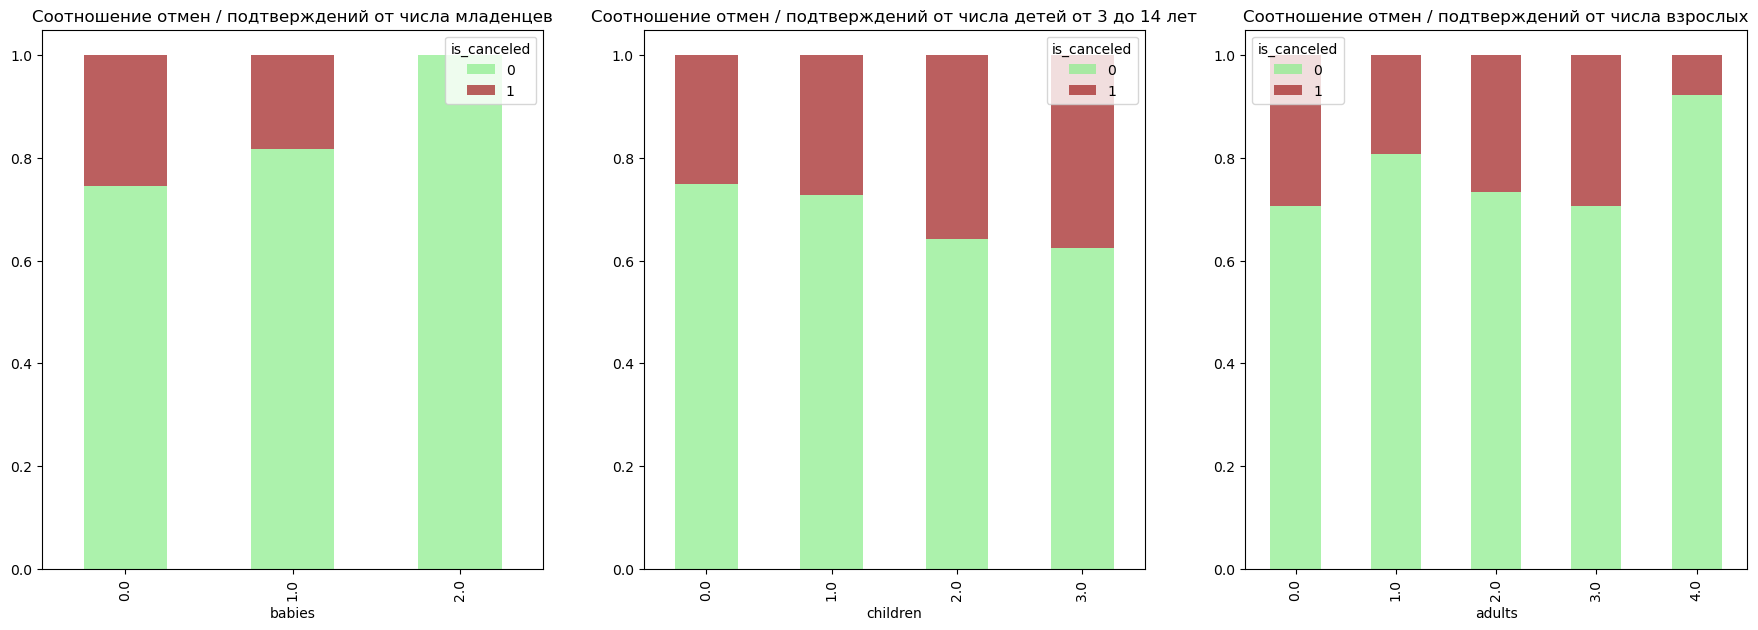

In [117]:
fig, ax = plt.subplots(1, 3, figsize=(22, 7))

cross_prob_bar('babies', ax[0])
ax[0].set_title('Соотношение отмен / подтверждений от числа младенцев')

cross_prob_bar('children', ax[1])
ax[1].set_title('Соотношение отмен / подтверждений от числа детей от 3 до 14 лет')

cross_prob_bar('adults', ax[2])
ax[2].set_title('Соотношение отмен / подтверждений от числа взрослых')

plt.show()

ЗАКЛЮЧЕНИЕ **№3**:
- без младенцев
- трое детей от 3-х до 14 лет
- без взрослых или 3-е взрослых

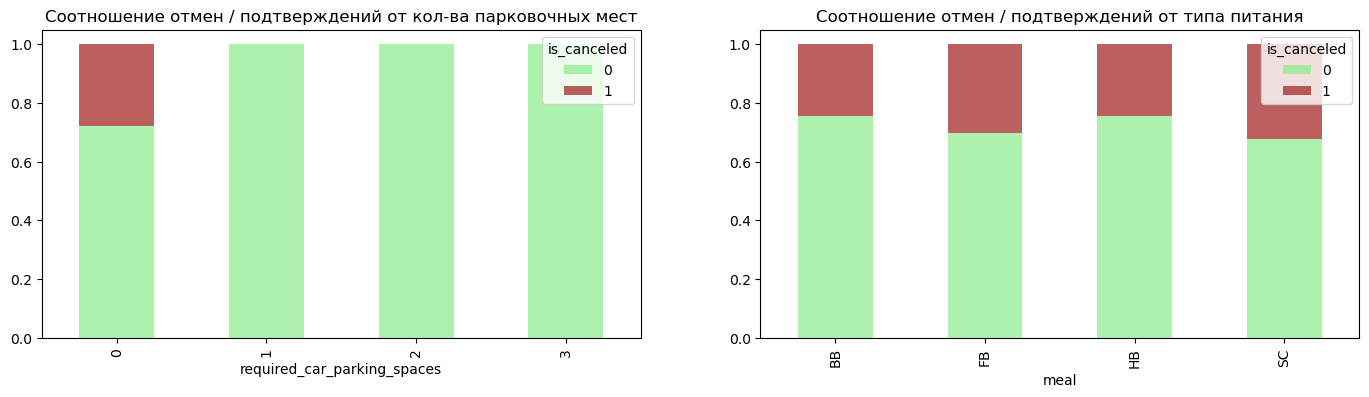

In [118]:
fig, ax = plt.subplots(1, 2, figsize=(17, 4))

cross_prob_bar('required_car_parking_spaces', ax[0])
ax[0].set_title('Соотношение отмен / подтверждений от кол-ва парковочных мест')

cross_prob_bar('meal', ax[1])
ax[1].set_title('Соотношение отмен / подтверждений от типа питания')

plt.show()

ЗАКЛЮЧЕНИЕ **№4**:
- не требуется место для парковки
- тип питания `FB` или `SC`

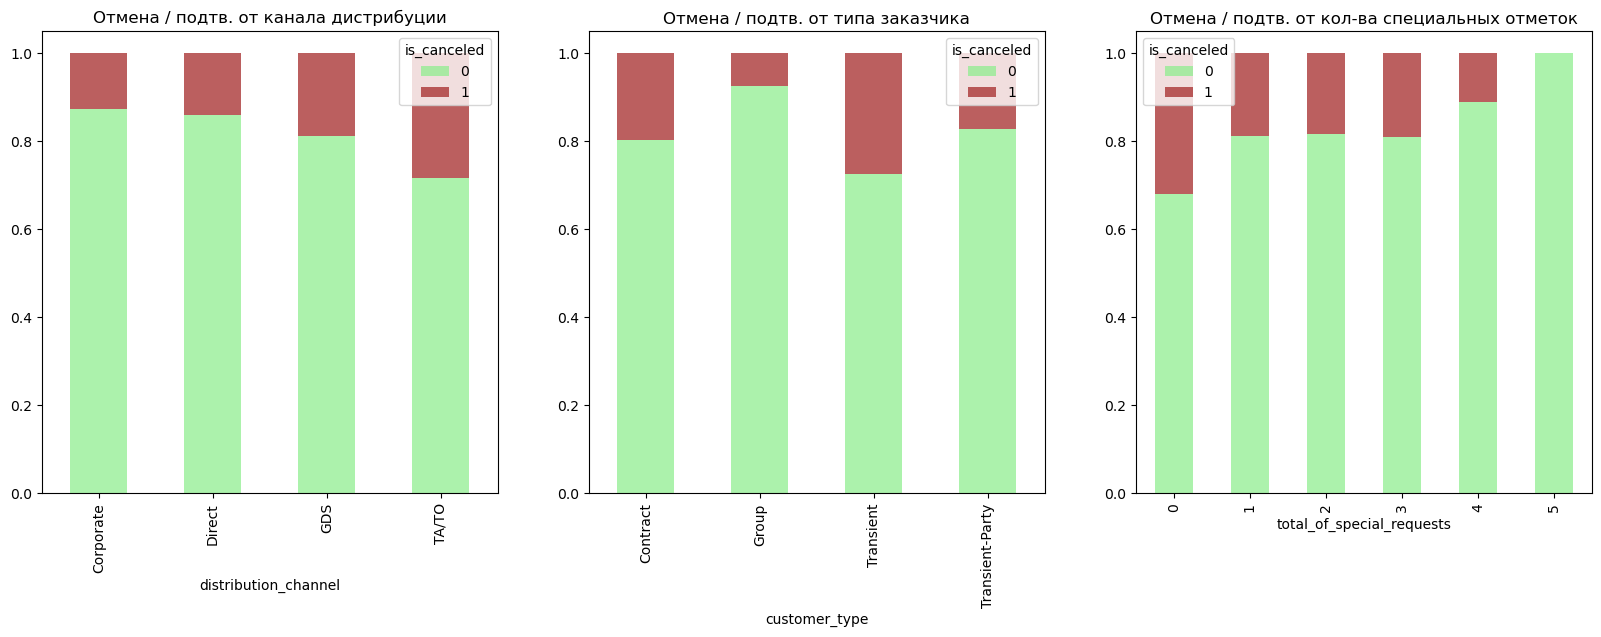

In [119]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

cross_prob_bar('distribution_channel', ax[0])
ax[0].set_title('Отмена / подтв. от канала дистрибуции')

cross_prob_bar('customer_type', ax[1])
ax[1].set_title('Отмена / подтв. от типа заказчика')

cross_prob_bar('total_of_special_requests', ax[2])
ax[2].set_title('Отмена / подтв. от кол-ва специальных отметок')

plt.show()

ЗАКЛЮЧЕНИЕ **№5**:
- канал дтистрибуции `TA/TO`
- тип заказчика `Transient`
- без специальных отметок (требований)

### Вывод

... собираем все пункты вместе! 

**Портрет "ненадежного" клиента:**

- чем больше время между датой бронирования и датой прибытия - тем больше вероятность отказа
- зона наиболее высокого риска отказа (`middle`), когда подтверждение о бронировании получено в диапазоне от 28 до 47 дней.
- гость из популярной страны
- прибытие назначено на пятницу
- высокий сезон (лето)
- без младенцев
- трое детей от 3-х до 14 лет
- без взрослых или 3-е взрослых
- не требуется место для парковки
- тип питания `FB` или `SC`
- канал дтистрибуции `TA/TO`
- тип заказчика `Transient`
- без специальных отметок (требований)


## Общий вывод

Основная задача работы - предложить модель, которая позволит увеличить выручку сети отелей предсказывая отказ от бронирования и позволяя минимизировать потери предлагая гостю внести депозит. Предложена модель, удовлетворяющая поставленной задаче, **логистическая регрессия**, которая на тестовых данных показала прирост выручки на `5.8 млн.` что значительно превышает затраты на внедрение, определенные в размере 400 000.